In [1]:
# Env: dqn_roost as of 15/1/2022 (after addition of ROOST)
import numpy as np
import pickle5 as pickle
import torch
from torch import nn
import collections
from model import DQN_pytorch, DCN_pytorch
import time
from one_hot import featurize_target, onehot_target, element_set, comp_set, one_hot_to_element, element_to_one_hot, one_hot_to_comp, comp_to_one_hot, step_to_one_hot, one_hot_to_step
import seaborn as sns
import random
import matplotlib.pyplot as plt
import os
from env_constrained import generate_random_act, ConstrainedMaterialEnvironment, extract_data_from_ep, generate_random_ep, predict_sinter, predict_calcine
import collections
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm 
from sklearn.manifold import TSNE
from numpy.linalg import svd
import imageio
from pymatgen.core import Composition
from constraints.checkers import check_neutrality, check_neutrality, check_neutrality_multiple, check_electronegativity_multiple, check_both_multiple
from matminer.featurizers.base import MultipleFeaturizer
import matminer.featurizers.composition as cf
from sklearn.ensemble import RandomForestRegressor
import joblib
from roost_models.roost_model import predict_formation_energy, predict_bulk_mod, predict_shear_mod, predict_band_gap
import json
from configs import configs
os.environ["CUDA_VISIBLE_DEVICES"]="3"
print(torch.cuda.is_available())
from metrics import similarity_to_nearest_neighbor
import pandas as pd
from matplotlib import gridspec
import matplotlib

/home/synthesisproject/anaconda3/envs/dqn_roost_EMD/lib/python3.7/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator DecisionTreeRegressor from version 0.23.2 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/home/synthesisproject/anaconda3/envs/dqn_roost_EMD/lib/python3.7/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator RandomForestRegressor from version 0.23.2 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


True


# Random baseline

In [2]:
# Load random oxides
with open('./training_data/random_oxides.pkl', 'rb') as f: 
    random_oxides = pickle.load(f)

# Charge neutrality and electronegativity
cn_random_good, cn_random_bad = check_neutrality_multiple(random_oxides)
en_random_good, en_random_bad = check_electronegativity_multiple(random_oxides)

form_e_random    = []
bulk_mod_random  = []
shear_mod_random = []
sintering_random = []
calcine_random   = []
bg_random        = []

for compound in tqdm(random_oxides):
    form_e_random.append(predict_formation_energy(compound))
for compound in tqdm(random_oxides):
    bulk_mod_random.append(predict_bulk_mod(compound))
for compound in tqdm(random_oxides):
    shear_mod_random.append(predict_shear_mod(compound))
for compound in tqdm(random_oxides):
    sintering_random.append(predict_sinter(compound))
for compound in tqdm(random_oxides):
    calcine_random.append(predict_calcine(compound))
for compound in tqdm(random_oxides):
    bg_random.append(predict_band_gap(compound))
random_oxides_EMD_mean, random_oxides_EMD_std = similarity_to_nearest_neighbor(random_oxides)

print('Random baseline:')
print('unique', len(set(random_oxides))/len(random_oxides))
print('charge neutral', len(cn_random_good)/(len(cn_random_good)+len(cn_random_bad)))
print('electronegativity balanced', len(en_random_good)/(len(en_random_good)+len(en_random_bad)))

print('form_e_mean', np.mean(form_e_random))
print('form_e_std', np.std(form_e_random))

print('bulk_mod_mean', np.mean(bulk_mod_random))
print('bulk_mod_std', np.std(bulk_mod_random))

print('shear_mod_mean', np.mean(shear_mod_random))
print('shear_mod_std', np.std(shear_mod_random))

print('sintering_mean', np.mean(sintering_random))
print('sintering_std', np.std(sintering_random))

print('calcine_mean', np.mean(calcine_random))
print('calcine_std', np.std(calcine_random))

print('band_gap_mean', np.mean(bg_random))
print('band_gap_std', np.std(bg_random))

print('EMD_mean', random_oxides_EMD_mean)
print('EMD_std', random_oxides_EMD_std)

 64%|██████▍   | 639/1000 [00:48<00:27, 13.22it/s]


KeyboardInterrupt: 

In [48]:
# Load random oxides
with open('./training_data/random_oxides-2.pkl', 'rb') as f: 
    random_oxides = pickle.load(f)
    
# Charge neutrality and electronegativity
cn_random_good, cn_random_bad = check_neutrality_multiple(random_oxides)
en_random_good, en_random_bad = check_electronegativity_multiple(random_oxides)

form_e_random    = []
bulk_mod_random  = []
shear_mod_random = []
sintering_random = []
calcine_random   = []# Load random oxides
with open('./training_data/random_oxides-2.pkl', 'rb') as f: 
    random_oxides = pickle.load(f)

# Charge neutrality and electronegativity
cn_random_good, cn_random_bad = check_neutrality_multiple(random_oxides)
en_random_good, en_random_bad = check_electronegativity_multiple(random_oxides)

form_e_random    = []
bulk_mod_random  = []
shear_mod_random = []
sintering_random = []
calcine_random   = []
bg_random        = []

for compound in tqdm(random_oxides):
    form_e_random.append(predict_formation_energy(compound))
for compound in tqdm(random_oxides):
    bulk_mod_random.append(predict_bulk_mod(compound))
for compound in tqdm(random_oxides):
    shear_mod_random.append(predict_shear_mod(compound))
for compound in tqdm(random_oxides):
    sintering_random.append(predict_sinter(compound))
for compound in tqdm(random_oxides):
    calcine_random.append(predict_calcine(compound))
for compound in tqdm(random_oxides):
    bg_random.append(predict_band_gap(compound))
random_oxides_EMD_mean, random_oxides_EMD_std = similarity_to_nearest_neighbor(random_oxides)

print('Random baseline:')
print('unique', len(set(random_oxides))/len(random_oxides))
print('charge neutral', len(cn_random_good)/(len(cn_random_good)+len(cn_random_bad)))
print('electronegativity balanced', len(en_random_good)/(len(en_random_good)+len(en_random_bad)))

print('form_e_mean', np.mean(form_e_random))
print('form_e_std', np.std(form_e_random))

print('bulk_mod_mean', np.mean(bulk_mod_random))
print('bulk_mod_std', np.std(bulk_mod_random))

print('shear_mod_mean', np.mean(shear_mod_random))
print('shear_mod_std', np.std(shear_mod_random))

print('sintering_mean', np.mean(sintering_random))
print('sintering_std', np.std(sintering_random))

print('calcine_mean', np.mean(calcine_random))
print('calcine_std', np.std(calcine_random))

print('band_gap_mean', np.mean(bg_random))
print('band_gap_std', np.std(bg_random))

print('EMD_mean', random_oxides_EMD_mean)
print('EMD_std', random_oxides_EMD_std)


100%|██████████| 1000/1000 [01:17<00:00, 12.84it/s]


Fitting mod_petti kernel matrix
Constructing distances
Parsing Formula


100%|██████████| 1000/1000 [00:00<00:00, 10842.48it/s]


Constructing joint compositional pairings


100%|██████████| 999/999 [00:00<00:00, 20313.71it/s]

Creating Process Pool
Scattering compositions between processes and computing distances


  0%|          | 0/999 [00:00<?, ?it/s]

Distances computed closing processes
Flattening sublists


100%|██████████| 1000/1000 [00:00<00:00, 9258.99it/s]

Average Element Mover's distance: 20.0488
Std Element Mover's distance: 9.7828
Random baseline:
unique 1.0
charge neutral 0.587
electronegativity balanced 0.42
form_e_mean -1.4151875623399393
form_e_std 0.7188623261388076
bulk_mod_mean 4.263697368621826
bulk_mod_std 0.6004355585154774
shear_mod_mean 3.643203038930893
shear_mod_std 0.7170473605979794
sintering_mean 1008.5398695850354
sintering_std 130.8149425120138
calcine_mean 904.9636730310777
calcine_std 72.29017468376551
band_gap_mean 0.6316121929883957
band_gap_std 0.6846788343101382
EMD_mean 20.048819003831824
EMD_std 9.782758073295991


In [49]:
# Load random oxides
with open('./training_data/random_oxides-3.pkl', 'rb') as f: 
    random_oxides = pickle.load(f)

# Charge neutrality and electronegativity
cn_random_good, cn_random_bad = check_neutrality_multiple(random_oxides)
en_random_good, en_random_bad = check_electronegativity_multiple(random_oxides)

form_e_random    = []
bulk_mod_random  = []
shear_mod_random = []
sintering_random = []
calcine_random   = []
bg_random        = []

for compound in tqdm(random_oxides):
    form_e_random.append(predict_formation_energy(compound))
for compound in tqdm(random_oxides):
    bulk_mod_random.append(predict_bulk_mod(compound))
for compound in tqdm(random_oxides):
    shear_mod_random.append(predict_shear_mod(compound))
for compound in tqdm(random_oxides):
    sintering_random.append(predict_sinter(compound))
for compound in tqdm(random_oxides):
    calcine_random.append(predict_calcine(compound))
for compound in tqdm(random_oxides):
    bg_random.append(predict_band_gap(compound))
random_oxides_EMD_mean, random_oxides_EMD_std = similarity_to_nearest_neighbor(random_oxides)

print('Random baseline:')
print('unique', len(set(random_oxides))/len(random_oxides))
print('charge neutral', len(cn_random_good)/(len(cn_random_good)+len(cn_random_bad)))
print('electronegativity balanced', len(en_random_good)/(len(en_random_good)+len(en_random_bad)))

print('form_e_mean', np.mean(form_e_random))
print('form_e_std', np.std(form_e_random))

print('bulk_mod_mean', np.mean(bulk_mod_random))
print('bulk_mod_std', np.std(bulk_mod_random))

print('shear_mod_mean', np.mean(shear_mod_random))
print('shear_mod_std', np.std(shear_mod_random))

print('sintering_mean', np.mean(sintering_random))
print('sintering_std', np.std(sintering_random))

print('calcine_mean', np.mean(calcine_random))
print('calcine_std', np.std(calcine_random))

print('band_gap_mean', np.mean(bg_random))
print('band_gap_std', np.std(bg_random))

print('EMD_mean', random_oxides_EMD_mean)
print('EMD_std', random_oxides_EMD_std)

100%|██████████| 1000/1000 [01:18<00:00, 12.82it/s]


Fitting mod_petti kernel matrix
Constructing distances
Parsing Formula


100%|██████████| 1000/1000 [00:00<00:00, 10839.06it/s]


Constructing joint compositional pairings


100%|██████████| 999/999 [00:00<00:00, 20199.72it/s]

Creating Process Pool
Scattering compositions between processes and computing distances


  0%|          | 0/999 [00:00<?, ?it/s]

Distances computed closing processes
Flattening sublists


100%|██████████| 1000/1000 [00:00<00:00, 9079.84it/s]

Average Element Mover's distance: 19.6471
Std Element Mover's distance: 9.4338
Random baseline:
unique 1.0
charge neutral 0.587
electronegativity balanced 0.412
form_e_mean -1.401432761335047
form_e_std 0.7082265678201058
bulk_mod_mean 4.2748829307556155
bulk_mod_std 0.6134983561994912
shear_mod_mean 3.6286604280471804
shear_mod_std 0.7356652831553542
sintering_mean 1005.792137741593
sintering_std 129.81555364079463
calcine_mean 902.7893374190692
calcine_std 70.71069374461189
band_gap_mean 0.6379839664697647
band_gap_std 0.6771980884166239
EMD_mean 19.647089558534528
EMD_std 9.433796321450885


# Formation energy task

In [3]:
# # Load random oxides
with open('./training_data/random_oxides.pkl', 'rb') as f: 
    random_oxides = pickle.load(f)

# Load compounds
with open('./training_data/oxides_form_e/final_compounds_roost_constrained.pkl', 'rb') as handle:
    final_compounds = pickle.load(handle)

# Formation Energy
form_e_random = []
form_e_trained = []
for compound in tqdm(random_oxides):
    form_e_random.append(predict_formation_energy(compound))
for compound in tqdm(final_compounds):
    form_e_trained.append(predict_formation_energy(compound))

# Charge neutrality and electronegativity
cn_random_good, cn_random_bad = check_neutrality_multiple(random_oxides)
en_random_good, en_random_bad = check_electronegativity_multiple(random_oxides)
cn_trained_good, cn_trained_bad = check_neutrality_multiple(final_compounds)
en_trained_good, en_trained_bad = check_electronegativity_multiple(final_compounds)

# Uniqueness
random_oxides_unique = list(set(random_oxides))
final_compounds_unique = list(set(final_compounds))

# EMD
random_oxides_EMD_mean, random_oxides_EMD_std = similarity_to_nearest_neighbor(random_oxides)
final_compounds_EMD_mean, final_compounds_EMD_std = similarity_to_nearest_neighbor(final_compounds)

results = {}
results['form_e_random_mean'] = np.mean(form_e_random)
results['form_e_random_std'] = np.std(form_e_random)
results['form_e_trained_mean'] = np.mean(form_e_trained)
results['form_e_trained_std'] = np.std(form_e_trained)
results['charge_neutral_random'] = len(cn_random_good)/(len(cn_random_good)+len(cn_random_bad))
results['electronegativity_balanced_random'] = len(en_random_good)/(len(en_random_good)+len(en_random_bad))
results['charge_neutral_trained'] = len(cn_trained_good)/(len(cn_trained_good)+len(cn_trained_bad))
results['electronegativity_balanced_trained'] = len(en_trained_good)/(len(en_trained_good)+len(en_trained_bad))
results['unique_random'] = len(random_oxides_unique)/len(random_oxides)
results['unique_trained'] = len(final_compounds_unique)/len(final_compounds)
results['random_oxides_EMD_mean'], results['random_oxides_EMD_std'] = random_oxides_EMD_mean, random_oxides_EMD_std
results['final_compounds_EMD_mean'], results['final_compounds_EMD_std'] = final_compounds_EMD_mean, final_compounds_EMD_std
results

100%|██████████| 1000/1000 [00:06<00:00, 147.03it/s]


Fitting mod_petti kernel matrix
Constructing distances
Parsing Formula


100%|██████████| 1000/1000 [00:00<00:00, 11038.16it/s]


Constructing joint compositional pairings


100%|██████████| 999/999 [00:00<00:00, 20834.50it/s]

Creating Process Pool
Scattering compositions between processes and computing distances


  0%|          | 0/999 [00:00<?, ?it/s]

Distances computed closing processes
Flattening sublists


100%|██████████| 1000/1000 [00:00<00:00, 9174.54it/s]


Average Element Mover's distance: 20.1286
Std Element Mover's distance: 9.8238
Fitting mod_petti kernel matrix
Constructing distances
Parsing Formula


100%|██████████| 1000/1000 [00:00<00:00, 11296.21it/s]


Constructing joint compositional pairings


100%|██████████| 999/999 [00:00<00:00, 20992.95it/s]

Creating Process Pool
Scattering compositions between processes and computing distances


  0%|          | 0/999 [00:00<?, ?it/s]

Distances computed closing processes
Flattening sublists


100%|██████████| 1000/1000 [00:00<00:00, 9329.84it/s]

Average Element Mover's distance: 14.1205
Std Element Mover's distance: 7.6154


{'form_e_random_mean': -1.3723867765516042,
 'form_e_random_std': 0.7347616392281606,
 'form_e_trained_mean': -2.5469348824471236,
 'form_e_trained_std': 0.7284008791384636,
 'charge_neutral_random': 0.599,
 'electronegativity_balanced_random': 0.428,
 'charge_neutral_trained': 0.601,
 'electronegativity_balanced_trained': 0.41,
 'unique_random': 1.0,
 'unique_trained': 1.0,
 'random_oxides_EMD_mean': 20.128644743593593,
 'random_oxides_EMD_std': 9.82379022238823,
 'final_compounds_EMD_mean': 14.120539936328331,
 'final_compounds_EMD_std': 7.615436575519054}

In [4]:
# # Load random oxides
with open('./training_data/random_oxides.pkl', 'rb') as f: 
    random_oxides = pickle.load(f)

# Load compounds
with open('./training_data/oxides_form_e-2/final_compounds_roost_constrained.pkl', 'rb') as handle:
    final_compounds = pickle.load(handle)

# Formation Energy
form_e_random = []
form_e_trained = []
for compound in tqdm(random_oxides):
    form_e_random.append(predict_formation_energy(compound))
for compound in tqdm(final_compounds):
    form_e_trained.append(predict_formation_energy(compound))
    
# Charge neutrality and electronegativity
cn_random_good, cn_random_bad = check_neutrality_multiple(random_oxides)
en_random_good, en_random_bad = check_electronegativity_multiple(random_oxides)
cn_trained_good, cn_trained_bad = check_neutrality_multiple(final_compounds)
en_trained_good, en_trained_bad = check_electronegativity_multiple(final_compounds)

# Uniqueness
random_oxides_unique = list(set(random_oxides))
final_compounds_unique = list(set(final_compounds))

# EMD
random_oxides_EMD_mean, random_oxides_EMD_std = similarity_to_nearest_neighbor(random_oxides)
final_compounds_EMD_mean, final_compounds_EMD_std = similarity_to_nearest_neighbor(final_compounds)

results = {}
results['form_e_random_mean'] = np.mean(form_e_random)
results['form_e_random_std'] = np.std(form_e_random)
results['form_e_trained_mean'] = np.mean(form_e_trained)
results['form_e_trained_std'] = np.std(form_e_trained)
results['charge_neutral_random'] = len(cn_random_good)/(len(cn_random_good)+len(cn_random_bad))
results['electronegativity_balanced_random'] = len(en_random_good)/(len(en_random_good)+len(en_random_bad))
results['charge_neutral_trained'] = len(cn_trained_good)/(len(cn_trained_good)+len(cn_trained_bad))
results['electronegativity_balanced_trained'] = len(en_trained_good)/(len(en_trained_good)+len(en_trained_bad))
results['unique_random'] = len(random_oxides_unique)/len(random_oxides)
results['unique_trained'] = len(final_compounds_unique)/len(final_compounds)
results['random_oxides_EMD_mean'], results['random_oxides_EMD_std'] = random_oxides_EMD_mean, random_oxides_EMD_std
results['final_compounds_EMD_mean'], results['final_compounds_EMD_std'] = final_compounds_EMD_mean, final_compounds_EMD_std
results

100%|██████████| 1000/1000 [01:16<00:00, 13.09it/s]


True


100%|██████████| 1000/1000 [00:11<00:00, 88.70it/s]


Fitting mod_petti kernel matrix
Constructing distances
Parsing Formula


100%|██████████| 1000/1000 [00:00<00:00, 10761.58it/s]


Constructing joint compositional pairings


100%|██████████| 999/999 [00:00<00:00, 20396.08it/s]

Creating Process Pool
Scattering compositions between processes and computing distances


  0%|          | 0/999 [00:00<?, ?it/s]

Distances computed closing processes
Flattening sublists


100%|██████████| 1000/1000 [00:00<00:00, 9079.15it/s]


Average Element Mover's distance: 20.1286
Std Element Mover's distance: 9.8238
Fitting mod_petti kernel matrix
Constructing distances
Parsing Formula


100%|██████████| 1000/1000 [00:00<00:00, 10810.26it/s]


Constructing joint compositional pairings


100%|██████████| 999/999 [00:00<00:00, 21255.13it/s]

Creating Process Pool
Scattering compositions between processes and computing distances


  0%|          | 0/999 [00:00<?, ?it/s]

Distances computed closing processes
Flattening sublists


100%|██████████| 1000/1000 [00:00<00:00, 9346.22it/s]

Average Element Mover's distance: 17.1555
Std Element Mover's distance: 9.6476


{'form_e_random_mean': -1.3723867765516042,
 'form_e_random_std': 0.7347616392281606,
 'form_e_trained_mean': -2.183434378352016,
 'form_e_trained_std': 0.7266618560071457,
 'charge_neutral_random': 0.599,
 'electronegativity_balanced_random': 0.428,
 'charge_neutral_trained': 0.819,
 'electronegativity_balanced_trained': 0.694,
 'unique_random': 1.0,
 'unique_trained': 0.996,
 'random_oxides_EMD_mean': 20.128644743593593,
 'random_oxides_EMD_std': 9.82379022238823,
 'final_compounds_EMD_mean': 17.15550955112312,
 'final_compounds_EMD_std': 9.647615886056496}

In [5]:
# # Load random oxides
with open('./training_data/random_oxides.pkl', 'rb') as f: 
    random_oxides = pickle.load(f)

# Load compounds
with open('./training_data/oxides_form_e-3/final_compounds_roost_constrained.pkl', 'rb') as handle:
    final_compounds = pickle.load(handle)

# Formation Energy
form_e_random = []
form_e_trained = []
for compound in tqdm(random_oxides):
    form_e_random.append(predict_formation_energy(compound))
for compound in tqdm(final_compounds):
    form_e_trained.append(predict_formation_energy(compound))
    
# Charge neutrality and electronegativity
cn_random_good, cn_random_bad = check_neutrality_multiple(random_oxides)
en_random_good, en_random_bad = check_electronegativity_multiple(random_oxides)
cn_trained_good, cn_trained_bad = check_neutrality_multiple(final_compounds)
en_trained_good, en_trained_bad = check_electronegativity_multiple(final_compounds)

# Uniqueness
random_oxides_unique = list(set(random_oxides))
final_compounds_unique = list(set(final_compounds))

# EMD
random_oxides_EMD_mean, random_oxides_EMD_std = similarity_to_nearest_neighbor(random_oxides)
final_compounds_EMD_mean, final_compounds_EMD_std = similarity_to_nearest_neighbor(final_compounds)

results = {}
results['form_e_random_mean'] = np.mean(form_e_random)
results['form_e_random_std'] = np.std(form_e_random)
results['form_e_trained_mean'] = np.mean(form_e_trained)
results['form_e_trained_std'] = np.std(form_e_trained)
results['charge_neutral_random'] = len(cn_random_good)/(len(cn_random_good)+len(cn_random_bad))
results['electronegativity_balanced_random'] = len(en_random_good)/(len(en_random_good)+len(en_random_bad))
results['charge_neutral_trained'] = len(cn_trained_good)/(len(cn_trained_good)+len(cn_trained_bad))
results['electronegativity_balanced_trained'] = len(en_trained_good)/(len(en_trained_good)+len(en_trained_bad))
results['unique_random'] = len(random_oxides_unique)/len(random_oxides)
results['unique_trained'] = len(final_compounds_unique)/len(final_compounds)
results['random_oxides_EMD_mean'], results['random_oxides_EMD_std'] = random_oxides_EMD_mean, random_oxides_EMD_std
results['final_compounds_EMD_mean'], results['final_compounds_EMD_std'] = final_compounds_EMD_mean, final_compounds_EMD_std
results

100%|██████████| 1000/1000 [00:19<00:00, 52.50it/s]


Fitting mod_petti kernel matrix
Constructing distances
Parsing Formula


100%|██████████| 1000/1000 [00:00<00:00, 7105.76it/s]


Constructing joint compositional pairings


100%|██████████| 999/999 [00:00<00:00, 13451.61it/s]

Creating Process Pool
Scattering compositions between processes and computing distances


  0%|          | 0/999 [00:00<?, ?it/s]

Distances computed closing processes
Flattening sublists


100%|██████████| 1000/1000 [00:00<00:00, 8673.80it/s]


Average Element Mover's distance: 20.1286
Std Element Mover's distance: 9.8238
Fitting mod_petti kernel matrix
Constructing distances
Parsing Formula


100%|██████████| 1000/1000 [00:00<00:00, 10968.54it/s]


Constructing joint compositional pairings


100%|██████████| 999/999 [00:00<00:00, 20707.44it/s]

Creating Process Pool
Scattering compositions between processes and computing distances


  0%|          | 0/999 [00:00<?, ?it/s]

Distances computed closing processes
Flattening sublists


100%|██████████| 1000/1000 [00:00<00:00, 9303.68it/s]

Average Element Mover's distance: 16.8692
Std Element Mover's distance: 8.6701


{'form_e_random_mean': -1.3723867808431387,
 'form_e_random_std': 0.7347616444293241,
 'form_e_trained_mean': -1.8930670890696346,
 'form_e_trained_std': 0.657108718005017,
 'charge_neutral_random': 0.599,
 'electronegativity_balanced_random': 0.428,
 'charge_neutral_trained': 0.524,
 'electronegativity_balanced_trained': 0.402,
 'unique_random': 1.0,
 'unique_trained': 0.999,
 'random_oxides_EMD_mean': 20.128644743593593,
 'random_oxides_EMD_std': 9.82379022238823,
 'final_compounds_EMD_mean': 16.869175883183186,
 'final_compounds_EMD_std': 8.670103903931441}

# Bulk modulus task

In [3]:
# # Load random oxides
with open('./training_data/random_oxides.pkl', 'rb') as f: 
    random_oxides = pickle.load(f)

# Load compounds
with open('./training_data/oxides_bulk_mod/final_compounds_roost_constrained.pkl', 'rb') as handle:
    final_compounds = pickle.load(handle)

# Formation Energy
form_e_random = []
form_e_trained = []
for compound in tqdm(random_oxides):
    form_e_random.append(predict_formation_energy(compound))
for compound in tqdm(final_compounds):
    form_e_trained.append(predict_formation_energy(compound))

# Bulk modulus
bulk_mod_random = []
bulk_mod_trained = []
for compound in tqdm(random_oxides):
    bulk_mod_random.append(predict_bulk_mod(compound))
for compound in tqdm(final_compounds):
    bulk_mod_trained.append(predict_bulk_mod(compound))

# Charge neutrality and electronegativity
cn_random_good, cn_random_bad = check_neutrality_multiple(random_oxides)
en_random_good, en_random_bad = check_electronegativity_multiple(random_oxides)
cn_trained_good, cn_trained_bad = check_neutrality_multiple(final_compounds)
en_trained_good, en_trained_bad = check_electronegativity_multiple(final_compounds)

# Uniqueness
random_oxides_unique = list(set(random_oxides))
final_compounds_unique = list(set(final_compounds))

# EMD
random_oxides_EMD_mean, random_oxides_EMD_std = similarity_to_nearest_neighbor(random_oxides)
final_compounds_EMD_mean, final_compounds_EMD_std = similarity_to_nearest_neighbor(final_compounds)

results = {}
results['form_e_random_mean'] = np.mean(form_e_random)
results['form_e_random_std'] = np.std(form_e_random)
results['form_e_trained_mean'] = np.mean(form_e_trained)
results['form_e_trained_std'] = np.std(form_e_trained)
results['bulk_mod_random_mean'] = np.mean(bulk_mod_random)
results['bulk_mod_random_std'] = np.std(bulk_mod_random)
results['bulk_mod_trained_mean'] = np.mean(bulk_mod_trained)
results['bulk_mod_trained_std'] = np.std(bulk_mod_trained)
results['charge_neutral_random'] = len(cn_random_good)/(len(cn_random_good)+len(cn_random_bad))
results['electronegativity_balanced_random'] = len(en_random_good)/(len(en_random_good)+len(en_random_bad))
results['charge_neutral_trained'] = len(cn_trained_good)/(len(cn_trained_good)+len(cn_trained_bad))
results['electronegativity_balanced_trained'] = len(en_trained_good)/(len(en_trained_good)+len(en_trained_bad))
results['unique_random'] = len(random_oxides_unique)/len(random_oxides)
results['unique_trained'] = len(final_compounds_unique)/len(final_compounds)
results['random_oxides_EMD_mean'], results['random_oxides_EMD_std'] = random_oxides_EMD_mean, random_oxides_EMD_std
results['final_compounds_EMD_mean'], results['final_compounds_EMD_std'] = final_compounds_EMD_mean, final_compounds_EMD_std
results

100%|██████████| 1000/1000 [00:00<00:00, 10399.03it/s]


Fitting mod_petti kernel matrix
Constructing distances
Parsing Formula


100%|██████████| 1000/1000 [00:00<00:00, 10640.20it/s]


Constructing joint compositional pairings


100%|██████████| 999/999 [00:00<00:00, 21227.57it/s]

Creating Process Pool
Scattering compositions between processes and computing distances


  0%|          | 0/999 [00:00<?, ?it/s]

Distances computed closing processes
Flattening sublists


100%|██████████| 1000/1000 [00:00<00:00, 9255.37it/s]


Average Element Mover's distance: 20.1286
Std Element Mover's distance: 9.8238


100%|██████████| 1000/1000 [00:00<00:00, 10307.47it/s]


Fitting mod_petti kernel matrix
Constructing distances
Parsing Formula


100%|██████████| 1000/1000 [00:00<00:00, 11365.38it/s]


Constructing joint compositional pairings


100%|██████████| 999/999 [00:00<00:00, 20665.26it/s]

Creating Process Pool
Scattering compositions between processes and computing distances


  0%|          | 0/999 [00:00<?, ?it/s]

Distances computed closing processes
Flattening sublists


100%|██████████| 1000/1000 [00:00<00:00, 9277.20it/s]

Average Element Mover's distance: 7.5943
Std Element Mover's distance: 4.0024


{'form_e_random_mean': -1.3723867772072553,
 'form_e_random_std': 0.7347616385105727,
 'form_e_trained_mean': -0.5865680969462265,
 'form_e_trained_std': 0.43989970302957976,
 'bulk_mod_random_mean': 4.29139886379242,
 'bulk_mod_random_std': 0.6012997229802703,
 'bulk_mod_trained_mean': 5.358326883792877,
 'bulk_mod_trained_std': 0.21379967833644037,
 'charge_neutral_random': 0.599,
 'electronegativity_balanced_random': 0.428,
 'charge_neutral_trained': 0.853,
 'electronegativity_balanced_trained': 0.658,
 'unique_random': 1.0,
 'unique_trained': 1.0,
 'random_oxides_EMD_mean': 20.128644743593593,
 'random_oxides_EMD_std': 9.82379022238823,
 'final_compounds_EMD_mean': 7.594290557421418,
 'final_compounds_EMD_std': 4.002392501670763}

In [6]:
# # Load random oxides
with open('./training_data/random_oxides.pkl', 'rb') as f: 
    random_oxides = pickle.load(f)

# Load compounds
with open('./training_data/oxides_bulk_mod-2/final_compounds_roost_constrained.pkl', 'rb') as handle:
    final_compounds = pickle.load(handle)

# Formation Energy
form_e_random = []
form_e_trained = []
for compound in tqdm(random_oxides):
    form_e_random.append(predict_formation_energy(compound))
for compound in tqdm(final_compounds):
    form_e_trained.append(predict_formation_energy(compound))

# Bulk modulus
bulk_mod_random = []
bulk_mod_trained = []
for compound in tqdm(random_oxides):
    bulk_mod_random.append(predict_bulk_mod(compound))
for compound in tqdm(final_compounds):
    bulk_mod_trained.append(predict_bulk_mod(compound))

# Charge neutrality and electronegativity
cn_random_good, cn_random_bad = check_neutrality_multiple(random_oxides)
en_random_good, en_random_bad = check_electronegativity_multiple(random_oxides)
cn_trained_good, cn_trained_bad = check_neutrality_multiple(final_compounds)
en_trained_good, en_trained_bad = check_electronegativity_multiple(final_compounds)

# Uniqueness
random_oxides_unique = list(set(random_oxides))
final_compounds_unique = list(set(final_compounds))

# EMD
random_oxides_EMD_mean, random_oxides_EMD_std = similarity_to_nearest_neighbor(random_oxides)
final_compounds_EMD_mean, final_compounds_EMD_std = similarity_to_nearest_neighbor(final_compounds)

results = {}
results['form_e_random_mean'] = np.mean(form_e_random)
results['form_e_random_std'] = np.std(form_e_random)
results['form_e_trained_mean'] = np.mean(form_e_trained)
results['form_e_trained_std'] = np.std(form_e_trained)
results['bulk_mod_random_mean'] = np.mean(bulk_mod_random)
results['bulk_mod_random_std'] = np.std(bulk_mod_random)
results['bulk_mod_trained_mean'] = np.mean(bulk_mod_trained)
results['bulk_mod_trained_std'] = np.std(bulk_mod_trained)
results['charge_neutral_random'] = len(cn_random_good)/(len(cn_random_good)+len(cn_random_bad))
results['electronegativity_balanced_random'] = len(en_random_good)/(len(en_random_good)+len(en_random_bad))
results['charge_neutral_trained'] = len(cn_trained_good)/(len(cn_trained_good)+len(cn_trained_bad))
results['electronegativity_balanced_trained'] = len(en_trained_good)/(len(en_trained_good)+len(en_trained_bad))
results['unique_random'] = len(random_oxides_unique)/len(random_oxides)
results['unique_trained'] = len(final_compounds_unique)/len(final_compounds)
results['random_oxides_EMD_mean'], results['random_oxides_EMD_std'] = random_oxides_EMD_mean, random_oxides_EMD_std
results['final_compounds_EMD_mean'], results['final_compounds_EMD_std'] = final_compounds_EMD_mean, final_compounds_EMD_std
results

100%|██████████| 1000/1000 [00:25<00:00, 39.24it/s]


Fitting mod_petti kernel matrix
Constructing distances
Parsing Formula


100%|██████████| 1000/1000 [00:00<00:00, 10612.45it/s]


Constructing joint compositional pairings


100%|██████████| 999/999 [00:00<00:00, 20094.43it/s]

Creating Process Pool
Scattering compositions between processes and computing distances


  0%|          | 0/999 [00:00<?, ?it/s]

Distances computed closing processes
Flattening sublists


100%|██████████| 1000/1000 [00:00<00:00, 9163.81it/s]


Average Element Mover's distance: 20.1286
Std Element Mover's distance: 9.8238
Fitting mod_petti kernel matrix
Constructing distances
Parsing Formula


100%|██████████| 1000/1000 [00:00<00:00, 11178.13it/s]


Constructing joint compositional pairings


100%|██████████| 999/999 [00:00<00:00, 20729.98it/s]

Creating Process Pool
Scattering compositions between processes and computing distances


  0%|          | 0/999 [00:00<?, ?it/s]

Distances computed closing processes
Flattening sublists


100%|██████████| 1000/1000 [00:00<00:00, 9311.36it/s]

Average Element Mover's distance: 12.1996
Std Element Mover's distance: 6.3377


{'form_e_random_mean': -1.3723867765516042,
 'form_e_random_std': 0.7347616392281606,
 'form_e_trained_mean': -0.8083103548130021,
 'form_e_trained_std': 0.6201761924841243,
 'bulk_mod_random_mean': 4.291398874282837,
 'bulk_mod_random_std': 0.6012997270469145,
 'bulk_mod_trained_mean': 5.167219559907913,
 'bulk_mod_trained_std': 0.37092244359097704,
 'charge_neutral_random': 0.599,
 'electronegativity_balanced_random': 0.428,
 'charge_neutral_trained': 0.869,
 'electronegativity_balanced_trained': 0.67,
 'unique_random': 1.0,
 'unique_trained': 0.995,
 'random_oxides_EMD_mean': 20.128644743593593,
 'random_oxides_EMD_std': 9.82379022238823,
 'final_compounds_EMD_mean': 12.199635581645651,
 'final_compounds_EMD_std': 6.337713801884294}

In [7]:
# # Load random oxides
with open('./training_data/random_oxides.pkl', 'rb') as f: 
    random_oxides = pickle.load(f)

# Load compounds
with open('./training_data/oxides_bulk_mod-3/final_compounds_roost_constrained.pkl', 'rb') as handle:
    final_compounds = pickle.load(handle)

# Formation Energy
form_e_random = []
form_e_trained = []
for compound in tqdm(random_oxides):
    form_e_random.append(predict_formation_energy(compound))
for compound in tqdm(final_compounds):
    form_e_trained.append(predict_formation_energy(compound))

# Bulk modulus
bulk_mod_random = []
bulk_mod_trained = []
for compound in tqdm(random_oxides):
    bulk_mod_random.append(predict_bulk_mod(compound))
for compound in tqdm(final_compounds):
    bulk_mod_trained.append(predict_bulk_mod(compound))

# Charge neutrality and electronegativity
cn_random_good, cn_random_bad = check_neutrality_multiple(random_oxides)
en_random_good, en_random_bad = check_electronegativity_multiple(random_oxides)
cn_trained_good, cn_trained_bad = check_neutrality_multiple(final_compounds)
en_trained_good, en_trained_bad = check_electronegativity_multiple(final_compounds)

# Uniqueness
random_oxides_unique = list(set(random_oxides))
final_compounds_unique = list(set(final_compounds))

# EMD
random_oxides_EMD_mean, random_oxides_EMD_std = similarity_to_nearest_neighbor(random_oxides)
final_compounds_EMD_mean, final_compounds_EMD_std = similarity_to_nearest_neighbor(final_compounds)

results = {}
results['form_e_random_mean'] = np.mean(form_e_random)
results['form_e_random_std'] = np.std(form_e_random)
results['form_e_trained_mean'] = np.mean(form_e_trained)
results['form_e_trained_std'] = np.std(form_e_trained)
results['bulk_mod_random_mean'] = np.mean(bulk_mod_random)
results['bulk_mod_random_std'] = np.std(bulk_mod_random)
results['bulk_mod_trained_mean'] = np.mean(bulk_mod_trained)
results['bulk_mod_trained_std'] = np.std(bulk_mod_trained)
results['charge_neutral_random'] = len(cn_random_good)/(len(cn_random_good)+len(cn_random_bad))
results['electronegativity_balanced_random'] = len(en_random_good)/(len(en_random_good)+len(en_random_bad))
results['charge_neutral_trained'] = len(cn_trained_good)/(len(cn_trained_good)+len(cn_trained_bad))
results['electronegativity_balanced_trained'] = len(en_trained_good)/(len(en_trained_good)+len(en_trained_bad))
results['unique_random'] = len(random_oxides_unique)/len(random_oxides)
results['unique_trained'] = len(final_compounds_unique)/len(final_compounds)
results['random_oxides_EMD_mean'], results['random_oxides_EMD_std'] = random_oxides_EMD_mean, random_oxides_EMD_std
results['final_compounds_EMD_mean'], results['final_compounds_EMD_std'] = final_compounds_EMD_mean, final_compounds_EMD_std
results

100%|██████████| 1000/1000 [00:30<00:00, 32.69it/s]


Fitting mod_petti kernel matrix
Constructing distances
Parsing Formula


100%|██████████| 1000/1000 [00:00<00:00, 10658.13it/s]


Constructing joint compositional pairings


100%|██████████| 999/999 [00:00<00:00, 20354.86it/s]

Creating Process Pool
Scattering compositions between processes and computing distances


  0%|          | 0/999 [00:00<?, ?it/s]

Distances computed closing processes
Flattening sublists


100%|██████████| 1000/1000 [00:00<00:00, 9197.29it/s]


Average Element Mover's distance: 20.1286
Std Element Mover's distance: 9.8238
Fitting mod_petti kernel matrix
Constructing distances
Parsing Formula


100%|██████████| 1000/1000 [00:00<00:00, 10975.37it/s]


Constructing joint compositional pairings


100%|██████████| 999/999 [00:00<00:00, 20742.40it/s]

Creating Process Pool
Scattering compositions between processes and computing distances


  0%|          | 0/999 [00:00<?, ?it/s]

Distances computed closing processes
Flattening sublists


100%|██████████| 1000/1000 [00:00<00:00, 9174.37it/s]

Average Element Mover's distance: 9.9843
Std Element Mover's distance: 4.9797


{'form_e_random_mean': -1.3723867765516042,
 'form_e_random_std': 0.7347616392281606,
 'form_e_trained_mean': -0.8012406534217298,
 'form_e_trained_std': 0.4721338600980419,
 'bulk_mod_random_mean': 4.291398874282837,
 'bulk_mod_random_std': 0.6012997270469145,
 'bulk_mod_trained_mean': 5.249165709733963,
 'bulk_mod_trained_std': 0.3226599100524071,
 'charge_neutral_random': 0.599,
 'electronegativity_balanced_random': 0.428,
 'charge_neutral_trained': 0.865,
 'electronegativity_balanced_trained': 0.689,
 'unique_random': 1.0,
 'unique_trained': 1.0,
 'random_oxides_EMD_mean': 20.128644743593593,
 'random_oxides_EMD_std': 9.82379022238823,
 'final_compounds_EMD_mean': 9.984299779149147,
 'final_compounds_EMD_std': 4.979681981499372}

# Shear modulus task

In [4]:
# # Load random oxides
with open('./training_data/random_oxides.pkl', 'rb') as f: 
    random_oxides = pickle.load(f)

# Load compounds
with open('./training_data/oxides_shear_mod/final_compounds_roost_constrained.pkl', 'rb') as handle:
    final_compounds = pickle.load(handle)

# Formation Energy
form_e_random = []
form_e_trained = []
for compound in tqdm(random_oxides):
    form_e_random.append(predict_formation_energy(compound))
for compound in tqdm(final_compounds):
    form_e_trained.append(predict_formation_energy(compound))

# Shear modulus
shear_mod_random = []
shear_mod_trained = []
for compound in tqdm(random_oxides):
    shear_mod_random.append(predict_shear_mod(compound))
for compound in tqdm(final_compounds):
    shear_mod_trained.append(predict_shear_mod(compound))

# Charge neutrality and electronegativity
cn_random_good, cn_random_bad = check_neutrality_multiple(random_oxides)
en_random_good, en_random_bad = check_electronegativity_multiple(random_oxides)
cn_trained_good, cn_trained_bad = check_neutrality_multiple(final_compounds)
en_trained_good, en_trained_bad = check_electronegativity_multiple(final_compounds)

# Uniqueness
random_oxides_unique = list(set(random_oxides))
final_compounds_unique = list(set(final_compounds))

# EMD
random_oxides_EMD_mean, random_oxides_EMD_std = similarity_to_nearest_neighbor(random_oxides)
final_compounds_EMD_mean, final_compounds_EMD_std = similarity_to_nearest_neighbor(final_compounds)

results = {}
results['form_e_random_mean'] = np.mean(form_e_random)
results['form_e_random_std'] = np.std(form_e_random)
results['form_e_trained_mean'] = np.mean(form_e_trained)
results['form_e_trained_std'] = np.std(form_e_trained)
results['shear_mod_random_mean'] = np.mean(shear_mod_random)
results['shear_mod_random_std'] = np.std(shear_mod_random)
results['shear_mod_trained_mean'] = np.mean(shear_mod_trained)
results['shear_mod_trained_std'] = np.std(shear_mod_trained)
results['charge_neutral_random'] = len(cn_random_good)/(len(cn_random_good)+len(cn_random_bad))
results['electronegativity_balanced_random'] = len(en_random_good)/(len(en_random_good)+len(en_random_bad))
results['charge_neutral_trained'] = len(cn_trained_good)/(len(cn_trained_good)+len(cn_trained_bad))
results['electronegativity_balanced_trained'] = len(en_trained_good)/(len(en_trained_good)+len(en_trained_bad))
results['unique_random'] = len(random_oxides_unique)/len(random_oxides)
results['unique_trained'] = len(final_compounds_unique)/len(final_compounds)
results['random_oxides_EMD_mean'], results['random_oxides_EMD_std'] = random_oxides_EMD_mean, random_oxides_EMD_std
results['final_compounds_EMD_mean'], results['final_compounds_EMD_std'] = final_compounds_EMD_mean, final_compounds_EMD_std
results

100%|██████████| 1000/1000 [00:00<00:00, 10276.58it/s]


Fitting mod_petti kernel matrix
Constructing distances
Parsing Formula


100%|██████████| 1000/1000 [00:00<00:00, 10472.17it/s]


Constructing joint compositional pairings


100%|██████████| 999/999 [00:00<00:00, 21341.74it/s]

Creating Process Pool
Scattering compositions between processes and computing distances


  0%|          | 0/999 [00:00<?, ?it/s]

Distances computed closing processes
Flattening sublists


100%|██████████| 1000/1000 [00:00<00:00, 9051.33it/s]


Average Element Mover's distance: 20.1286
Std Element Mover's distance: 9.8238


100%|██████████| 1000/1000 [00:00<00:00, 10122.54it/s]


Fitting mod_petti kernel matrix
Constructing distances
Parsing Formula


100%|██████████| 1000/1000 [00:00<00:00, 10606.35it/s]


Constructing joint compositional pairings


100%|██████████| 999/999 [00:00<00:00, 20710.72it/s]

Creating Process Pool
Scattering compositions between processes and computing distances


  0%|          | 0/999 [00:00<?, ?it/s]

Distances computed closing processes
Flattening sublists


100%|██████████| 1000/1000 [00:00<00:00, 9388.00it/s]

Average Element Mover's distance: 11.0803
Std Element Mover's distance: 5.09


{'form_e_random_mean': -1.3723867765516042,
 'form_e_random_std': 0.7347616392281606,
 'form_e_trained_mean': -1.0089453325352515,
 'form_e_trained_std': 0.5557614357089498,
 'shear_mod_random_mean': 3.6573499751091005,
 'shear_mod_random_std': 0.7215814376106682,
 'shear_mod_trained_mean': 4.462840408086777,
 'shear_mod_trained_std': 0.4064563218900934,
 'charge_neutral_random': 0.599,
 'electronegativity_balanced_random': 0.428,
 'charge_neutral_trained': 0.828,
 'electronegativity_balanced_trained': 0.692,
 'unique_random': 1.0,
 'unique_trained': 1.0,
 'random_oxides_EMD_mean': 20.128644743593593,
 'random_oxides_EMD_std': 9.82379022238823,
 'final_compounds_EMD_mean': 11.080325785915916,
 'final_compounds_EMD_std': 5.090006029103403}

In [8]:
# # Load random oxides
with open('./training_data/random_oxides.pkl', 'rb') as f: 
    random_oxides = pickle.load(f)

# Load compounds
with open('./training_data/oxides_shear_mod-2/final_compounds_roost_constrained.pkl', 'rb') as handle:
    final_compounds = pickle.load(handle)

# Formation Energy
form_e_random = []
form_e_trained = []
for compound in tqdm(random_oxides):
    form_e_random.append(predict_formation_energy(compound))
for compound in tqdm(final_compounds):
    form_e_trained.append(predict_formation_energy(compound))

# Shear modulus
shear_mod_random = []
shear_mod_trained = []
for compound in tqdm(random_oxides):
    shear_mod_random.append(predict_shear_mod(compound))
for compound in tqdm(final_compounds):
    shear_mod_trained.append(predict_shear_mod(compound))

# Charge neutrality and electronegativity
cn_random_good, cn_random_bad = check_neutrality_multiple(random_oxides)
en_random_good, en_random_bad = check_electronegativity_multiple(random_oxides)
cn_trained_good, cn_trained_bad = check_neutrality_multiple(final_compounds)
en_trained_good, en_trained_bad = check_electronegativity_multiple(final_compounds)

# Uniqueness
random_oxides_unique = list(set(random_oxides))
final_compounds_unique = list(set(final_compounds))

# EMD
random_oxides_EMD_mean, random_oxides_EMD_std = similarity_to_nearest_neighbor(random_oxides)
final_compounds_EMD_mean, final_compounds_EMD_std = similarity_to_nearest_neighbor(final_compounds)

results = {}
results['form_e_random_mean'] = np.mean(form_e_random)
results['form_e_random_std'] = np.std(form_e_random)
results['form_e_trained_mean'] = np.mean(form_e_trained)
results['form_e_trained_std'] = np.std(form_e_trained)
results['shear_mod_random_mean'] = np.mean(shear_mod_random)
results['shear_mod_random_std'] = np.std(shear_mod_random)
results['shear_mod_trained_mean'] = np.mean(shear_mod_trained)
results['shear_mod_trained_std'] = np.std(shear_mod_trained)
results['charge_neutral_random'] = len(cn_random_good)/(len(cn_random_good)+len(cn_random_bad))
results['electronegativity_balanced_random'] = len(en_random_good)/(len(en_random_good)+len(en_random_bad))
results['charge_neutral_trained'] = len(cn_trained_good)/(len(cn_trained_good)+len(cn_trained_bad))
results['electronegativity_balanced_trained'] = len(en_trained_good)/(len(en_trained_good)+len(en_trained_bad))
results['unique_random'] = len(random_oxides_unique)/len(random_oxides)
results['unique_trained'] = len(final_compounds_unique)/len(final_compounds)
results['random_oxides_EMD_mean'], results['random_oxides_EMD_std'] = random_oxides_EMD_mean, random_oxides_EMD_std
results['final_compounds_EMD_mean'], results['final_compounds_EMD_std'] = final_compounds_EMD_mean, final_compounds_EMD_std
results

100%|██████████| 1000/1000 [00:27<00:00, 36.41it/s]


Fitting mod_petti kernel matrix
Constructing distances
Parsing Formula


100%|██████████| 1000/1000 [00:00<00:00, 10609.33it/s]


Constructing joint compositional pairings


100%|██████████| 999/999 [00:00<00:00, 19884.35it/s]

Creating Process Pool
Scattering compositions between processes and computing distances


  0%|          | 0/999 [00:00<?, ?it/s]

Distances computed closing processes
Flattening sublists


100%|██████████| 1000/1000 [00:00<00:00, 9065.26it/s]


Average Element Mover's distance: 20.1286
Std Element Mover's distance: 9.8238
Fitting mod_petti kernel matrix
Constructing distances
Parsing Formula


100%|██████████| 1000/1000 [00:00<00:00, 10723.28it/s]


Constructing joint compositional pairings


100%|██████████| 999/999 [00:00<00:00, 20943.22it/s]

Creating Process Pool
Scattering compositions between processes and computing distances


  0%|          | 0/999 [00:00<?, ?it/s]

Distances computed closing processes
Flattening sublists


100%|██████████| 1000/1000 [00:00<00:00, 9143.04it/s]

Average Element Mover's distance: 10.5972
Std Element Mover's distance: 5.3439


{'form_e_random_mean': -1.3723867765516042,
 'form_e_random_std': 0.7347616392281606,
 'form_e_trained_mean': -0.9580242489743978,
 'form_e_trained_std': 0.43892841157107365,
 'shear_mod_random_mean': 3.657350149154663,
 'shear_mod_random_std': 0.7215814227943422,
 'shear_mod_trained_mean': 4.492612731218338,
 'shear_mod_trained_std': 0.3036665876059667,
 'charge_neutral_random': 0.599,
 'electronegativity_balanced_random': 0.428,
 'charge_neutral_trained': 0.876,
 'electronegativity_balanced_trained': 0.758,
 'unique_random': 1.0,
 'unique_trained': 1.0,
 'random_oxides_EMD_mean': 20.128644743593593,
 'random_oxides_EMD_std': 9.82379022238823,
 'final_compounds_EMD_mean': 10.597175819733732,
 'final_compounds_EMD_std': 5.3438505218865116}

In [9]:
# # Load random oxides
with open('./training_data/random_oxides.pkl', 'rb') as f: 
    random_oxides = pickle.load(f)

# Load compounds
with open('./training_data/oxides_shear_mod-3/final_compounds_roost_constrained.pkl', 'rb') as handle:
    final_compounds = pickle.load(handle)

# Formation Energy
form_e_random = []
form_e_trained = []
for compound in tqdm(random_oxides):
    form_e_random.append(predict_formation_energy(compound))
for compound in tqdm(final_compounds):
    form_e_trained.append(predict_formation_energy(compound))

# Shear modulus
shear_mod_random = []
shear_mod_trained = []
for compound in tqdm(random_oxides):
    shear_mod_random.append(predict_shear_mod(compound))
for compound in tqdm(final_compounds):
    shear_mod_trained.append(predict_shear_mod(compound))

# Charge neutrality and electronegativity
cn_random_good, cn_random_bad = check_neutrality_multiple(random_oxides)
en_random_good, en_random_bad = check_electronegativity_multiple(random_oxides)
cn_trained_good, cn_trained_bad = check_neutrality_multiple(final_compounds)
en_trained_good, en_trained_bad = check_electronegativity_multiple(final_compounds)

# Uniqueness
random_oxides_unique = list(set(random_oxides))
final_compounds_unique = list(set(final_compounds))

# EMD
random_oxides_EMD_mean, random_oxides_EMD_std = similarity_to_nearest_neighbor(random_oxides)
final_compounds_EMD_mean, final_compounds_EMD_std = similarity_to_nearest_neighbor(final_compounds)

results = {}
results['form_e_random_mean'] = np.mean(form_e_random)
results['form_e_random_std'] = np.std(form_e_random)
results['form_e_trained_mean'] = np.mean(form_e_trained)
results['form_e_trained_std'] = np.std(form_e_trained)
results['shear_mod_random_mean'] = np.mean(shear_mod_random)
results['shear_mod_random_std'] = np.std(shear_mod_random)
results['shear_mod_trained_mean'] = np.mean(shear_mod_trained)
results['shear_mod_trained_std'] = np.std(shear_mod_trained)
results['charge_neutral_random'] = len(cn_random_good)/(len(cn_random_good)+len(cn_random_bad))
results['electronegativity_balanced_random'] = len(en_random_good)/(len(en_random_good)+len(en_random_bad))
results['charge_neutral_trained'] = len(cn_trained_good)/(len(cn_trained_good)+len(cn_trained_bad))
results['electronegativity_balanced_trained'] = len(en_trained_good)/(len(en_trained_good)+len(en_trained_bad))
results['unique_random'] = len(random_oxides_unique)/len(random_oxides)
results['unique_trained'] = len(final_compounds_unique)/len(final_compounds)
results['random_oxides_EMD_mean'], results['random_oxides_EMD_std'] = random_oxides_EMD_mean, random_oxides_EMD_std
results['final_compounds_EMD_mean'], results['final_compounds_EMD_std'] = final_compounds_EMD_mean, final_compounds_EMD_std
results

100%|██████████| 1000/1000 [00:27<00:00, 36.94it/s]


Fitting mod_petti kernel matrix
Constructing distances
Parsing Formula


100%|██████████| 1000/1000 [00:00<00:00, 10492.63it/s]


Constructing joint compositional pairings


100%|██████████| 999/999 [00:00<00:00, 20248.73it/s]

Creating Process Pool
Scattering compositions between processes and computing distances


  0%|          | 0/999 [00:00<?, ?it/s]

Distances computed closing processes
Flattening sublists


100%|██████████| 1000/1000 [00:00<00:00, 9165.35it/s]


Average Element Mover's distance: 20.1286
Std Element Mover's distance: 9.8238
Fitting mod_petti kernel matrix
Constructing distances
Parsing Formula


100%|██████████| 1000/1000 [00:00<00:00, 10815.25it/s]


Constructing joint compositional pairings


100%|██████████| 999/999 [00:00<00:00, 20878.00it/s]

Creating Process Pool
Scattering compositions between processes and computing distances


  0%|          | 0/999 [00:00<?, ?it/s]

Distances computed closing processes
Flattening sublists


100%|██████████| 1000/1000 [00:00<00:00, 9193.80it/s]

Average Element Mover's distance: 10.7817
Std Element Mover's distance: 5.1995


{'form_e_random_mean': -1.3723867765516042,
 'form_e_random_std': 0.7347616392281606,
 'form_e_trained_mean': -1.1577364917231026,
 'form_e_trained_std': 0.5619516661849194,
 'shear_mod_random_mean': 3.657350149154663,
 'shear_mod_random_std': 0.7215814227943422,
 'shear_mod_trained_mean': 4.534566444039345,
 'shear_mod_trained_std': 0.3312451432079021,
 'charge_neutral_random': 0.599,
 'electronegativity_balanced_random': 0.428,
 'charge_neutral_trained': 0.933,
 'electronegativity_balanced_trained': 0.778,
 'unique_random': 1.0,
 'unique_trained': 1.0,
 'random_oxides_EMD_mean': 20.128644743593593,
 'random_oxides_EMD_std': 9.82379022238823,
 'final_compounds_EMD_mean': 10.781655953193187,
 'final_compounds_EMD_std': 5.199520828778767}

# Sintering temp task

In [13]:
# # Load random oxides
with open('./training_data/random_oxides.pkl', 'rb') as f: 
    random_oxides = pickle.load(f)

# Load compounds
with open('./training_data/oxides_sinter/final_compounds_RF_constrained.pkl', 'rb') as handle:
    final_compounds = pickle.load(handle)

# Formation Energy
form_e_random = []
form_e_trained = []
for compound in tqdm(random_oxides):
    form_e_random.append(predict_formation_energy(compound))
for compound in tqdm(final_compounds):
    form_e_trained.append(predict_formation_energy(compound))

# Sintering temp
sintering_random = []
sintering_trained = []
for compound in tqdm(random_oxides):
    sintering_random.append(predict_sinter(compound))
for compound in tqdm(final_compounds):
    sintering_trained.append(predict_sinter(compound))

# Charge neutrality and electronegativity
cn_random_good, cn_random_bad = check_neutrality_multiple(random_oxides)
en_random_good, en_random_bad = check_electronegativity_multiple(random_oxides)
cn_trained_good, cn_trained_bad = check_neutrality_multiple(final_compounds)
en_trained_good, en_trained_bad = check_electronegativity_multiple(final_compounds)

# Uniqueness
random_oxides_unique = list(set(random_oxides))
final_compounds_unique = list(set(final_compounds))

# EMD
random_oxides_EMD_mean, random_oxides_EMD_std = similarity_to_nearest_neighbor(random_oxides)
final_compounds_EMD_mean, final_compounds_EMD_std = similarity_to_nearest_neighbor(final_compounds)

results = {}
results['form_e_random_mean'] = np.mean(form_e_random)
results['form_e_random_std'] = np.std(form_e_random)
results['form_e_trained_mean'] = np.mean(form_e_trained)
results['form_e_trained_std'] = np.std(form_e_trained)
results['sintering_random_mean'] = np.mean(sintering_random)
results['sintering_random_std'] = np.std(sintering_random)
results['sintering_trained_mean'] = np.mean(sintering_trained)
results['sintering_trained_std'] = np.std(sintering_trained)
results['charge_neutral_random'] = len(cn_random_good)/(len(cn_random_good)+len(cn_random_bad))
results['electronegativity_balanced_random'] = len(en_random_good)/(len(en_random_good)+len(en_random_bad))
results['charge_neutral_trained'] = len(cn_trained_good)/(len(cn_trained_good)+len(cn_trained_bad))
results['electronegativity_balanced_trained'] = len(en_trained_good)/(len(en_trained_good)+len(en_trained_bad))
results['unique_random'] = len(random_oxides_unique)/len(random_oxides)
results['unique_trained'] = len(final_compounds_unique)/len(final_compounds)
results['random_oxides_EMD_mean'], results['random_oxides_EMD_std'] = random_oxides_EMD_mean, random_oxides_EMD_std
results['final_compounds_EMD_mean'], results['final_compounds_EMD_std'] = final_compounds_EMD_mean, final_compounds_EMD_std
results

100%|██████████| 1000/1000 [00:17<00:00, 58.36it/s]


Fitting mod_petti kernel matrix
Constructing distances
Parsing Formula


100%|██████████| 1000/1000 [00:00<00:00, 10617.15it/s]


Constructing joint compositional pairings


100%|██████████| 999/999 [00:00<00:00, 20671.18it/s]

Creating Process Pool
Scattering compositions between processes and computing distances


  0%|          | 0/999 [00:00<?, ?it/s]

Distances computed closing processes
Flattening sublists


100%|██████████| 1000/1000 [00:00<00:00, 9086.43it/s]


Average Element Mover's distance: 20.1286
Std Element Mover's distance: 9.8238
Fitting mod_petti kernel matrix
Constructing distances
Parsing Formula


100%|██████████| 1000/1000 [00:00<00:00, 10888.78it/s]


Constructing joint compositional pairings


100%|██████████| 999/999 [00:00<00:00, 20894.55it/s]

Creating Process Pool
Scattering compositions between processes and computing distances


  0%|          | 0/999 [00:00<?, ?it/s]

Distances computed closing processes
Flattening sublists


100%|██████████| 1000/1000 [00:00<00:00, 9188.50it/s]

Average Element Mover's distance: 12.1047
Std Element Mover's distance: 7.4317


{'form_e_random_mean': -1.3723867772072553,
 'form_e_random_std': 0.7347616385105727,
 'form_e_trained_mean': -1.0209875393921974,
 'form_e_trained_std': 0.507839532848521,
 'sintering_random_mean': 1011.1405443517411,
 'sintering_random_std': 131.0925303880326,
 'sintering_trained_mean': 827.3537152992774,
 'sintering_trained_std': 98.18427515077079,
 'charge_neutral_random': 0.599,
 'electronegativity_balanced_random': 0.428,
 'charge_neutral_trained': 0.857,
 'electronegativity_balanced_trained': 0.647,
 'unique_random': 1.0,
 'unique_trained': 1.0,
 'random_oxides_EMD_mean': 20.128644743593593,
 'random_oxides_EMD_std': 9.82379022238823,
 'final_compounds_EMD_mean': 12.104689121839847,
 'final_compounds_EMD_std': 7.4317252571245325}

In [11]:
# # Load random oxides
with open('./training_data/random_oxides.pkl', 'rb') as f: 
    random_oxides = pickle.load(f)

# Load compounds
with open('./training_data/oxides_sinter-2/final_compounds_RF_constrained.pkl', 'rb') as handle:
    final_compounds = pickle.load(handle)

# Formation Energy
form_e_random = []
form_e_trained = []
for compound in tqdm(random_oxides):
    form_e_random.append(predict_formation_energy(compound))
for compound in tqdm(final_compounds):
    form_e_trained.append(predict_formation_energy(compound))

# Sintering temp
sintering_random = []
sintering_trained = []
for compound in tqdm(random_oxides):
    sintering_random.append(predict_sinter(compound))
for compound in tqdm(final_compounds):
    sintering_trained.append(predict_sinter(compound))

# Charge neutrality and electronegativity
cn_random_good, cn_random_bad = check_neutrality_multiple(random_oxides)
en_random_good, en_random_bad = check_electronegativity_multiple(random_oxides)
cn_trained_good, cn_trained_bad = check_neutrality_multiple(final_compounds)
en_trained_good, en_trained_bad = check_electronegativity_multiple(final_compounds)

# Uniqueness
random_oxides_unique = list(set(random_oxides))
final_compounds_unique = list(set(final_compounds))

# EMD
random_oxides_EMD_mean, random_oxides_EMD_std = similarity_to_nearest_neighbor(random_oxides)
final_compounds_EMD_mean, final_compounds_EMD_std = similarity_to_nearest_neighbor(final_compounds)

results = {}
results['form_e_random_mean'] = np.mean(form_e_random)
results['form_e_random_std'] = np.std(form_e_random)
results['form_e_trained_mean'] = np.mean(form_e_trained)
results['form_e_trained_std'] = np.std(form_e_trained)
results['sintering_random_mean'] = np.mean(sintering_random)
results['sintering_random_std'] = np.std(sintering_random)
results['sintering_trained_mean'] = np.mean(sintering_trained)
results['sintering_trained_std'] = np.std(sintering_trained)
results['charge_neutral_random'] = len(cn_random_good)/(len(cn_random_good)+len(cn_random_bad))
results['electronegativity_balanced_random'] = len(en_random_good)/(len(en_random_good)+len(en_random_bad))
results['charge_neutral_trained'] = len(cn_trained_good)/(len(cn_trained_good)+len(cn_trained_bad))
results['electronegativity_balanced_trained'] = len(en_trained_good)/(len(en_trained_good)+len(en_trained_bad))
results['unique_random'] = len(random_oxides_unique)/len(random_oxides)
results['unique_trained'] = len(final_compounds_unique)/len(final_compounds)
results['random_oxides_EMD_mean'], results['random_oxides_EMD_std'] = random_oxides_EMD_mean, random_oxides_EMD_std
results['final_compounds_EMD_mean'], results['final_compounds_EMD_std'] = final_compounds_EMD_mean, final_compounds_EMD_std
results

100%|██████████| 1000/1000 [00:13<00:00, 74.69it/s]


Fitting mod_petti kernel matrix
Constructing distances
Parsing Formula


100%|██████████| 1000/1000 [00:00<00:00, 10586.17it/s]


Constructing joint compositional pairings


100%|██████████| 999/999 [00:00<00:00, 4507.89it/s]

Creating Process Pool
Scattering compositions between processes and computing distances


  0%|          | 0/999 [00:00<?, ?it/s]

Distances computed closing processes
Flattening sublists


100%|██████████| 1000/1000 [00:00<00:00, 8965.52it/s]


Average Element Mover's distance: 20.1286
Std Element Mover's distance: 9.8238
Fitting mod_petti kernel matrix
Constructing distances
Parsing Formula


100%|██████████| 1000/1000 [00:00<00:00, 10929.78it/s]


Constructing joint compositional pairings


100%|██████████| 999/999 [00:00<00:00, 21020.23it/s]

Creating Process Pool
Scattering compositions between processes and computing distances


  0%|          | 0/999 [00:00<?, ?it/s]

Distances computed closing processes
Flattening sublists


100%|██████████| 1000/1000 [00:00<00:00, 9178.07it/s]

Average Element Mover's distance: 15.6503
Std Element Mover's distance: 8.2289


{'form_e_random_mean': -1.3723867772072553,
 'form_e_random_std': 0.7347616385105727,
 'form_e_trained_mean': -0.9604749636020279,
 'form_e_trained_std': 0.5636414183828485,
 'sintering_random_mean': 1011.1405443517411,
 'sintering_random_std': 131.0925303880326,
 'sintering_trained_mean': 806.4426254209793,
 'sintering_trained_std': 94.89593433672087,
 'charge_neutral_random': 0.599,
 'electronegativity_balanced_random': 0.428,
 'charge_neutral_trained': 0.843,
 'electronegativity_balanced_trained': 0.614,
 'unique_random': 1.0,
 'unique_trained': 1.0,
 'random_oxides_EMD_mean': 20.128644743593593,
 'random_oxides_EMD_std': 9.82379022238823,
 'final_compounds_EMD_mean': 15.650284433851853,
 'final_compounds_EMD_std': 8.228864886422718}

In [12]:
# # Load random oxides
with open('./training_data/random_oxides.pkl', 'rb') as f: 
    random_oxides = pickle.load(f)

# Load compounds
with open('./training_data/oxides_sinter-3/final_compounds_RF_constrained.pkl', 'rb') as handle:
    final_compounds = pickle.load(handle)

# Formation Energy
form_e_random = []
form_e_trained = []
for compound in tqdm(random_oxides):
    form_e_random.append(predict_formation_energy(compound))
for compound in tqdm(final_compounds):
    form_e_trained.append(predict_formation_energy(compound))

# Sintering temp
sintering_random = []
sintering_trained = []
for compound in tqdm(random_oxides):
    sintering_random.append(predict_sinter(compound))
for compound in tqdm(final_compounds):
    sintering_trained.append(predict_sinter(compound))

# Charge neutrality and electronegativity
cn_random_good, cn_random_bad = check_neutrality_multiple(random_oxides)
en_random_good, en_random_bad = check_electronegativity_multiple(random_oxides)
cn_trained_good, cn_trained_bad = check_neutrality_multiple(final_compounds)
en_trained_good, en_trained_bad = check_electronegativity_multiple(final_compounds)

# Uniqueness
random_oxides_unique = list(set(random_oxides))
final_compounds_unique = list(set(final_compounds))

# EMD
random_oxides_EMD_mean, random_oxides_EMD_std = similarity_to_nearest_neighbor(random_oxides)
final_compounds_EMD_mean, final_compounds_EMD_std = similarity_to_nearest_neighbor(final_compounds)

results = {}
results['form_e_random_mean'] = np.mean(form_e_random)
results['form_e_random_std'] = np.std(form_e_random)
results['form_e_trained_mean'] = np.mean(form_e_trained)
results['form_e_trained_std'] = np.std(form_e_trained)
results['sintering_random_mean'] = np.mean(sintering_random)
results['sintering_random_std'] = np.std(sintering_random)
results['sintering_trained_mean'] = np.mean(sintering_trained)
results['sintering_trained_std'] = np.std(sintering_trained)
results['charge_neutral_random'] = len(cn_random_good)/(len(cn_random_good)+len(cn_random_bad))
results['electronegativity_balanced_random'] = len(en_random_good)/(len(en_random_good)+len(en_random_bad))
results['charge_neutral_trained'] = len(cn_trained_good)/(len(cn_trained_good)+len(cn_trained_bad))
results['electronegativity_balanced_trained'] = len(en_trained_good)/(len(en_trained_good)+len(en_trained_bad))
results['unique_random'] = len(random_oxides_unique)/len(random_oxides)
results['unique_trained'] = len(final_compounds_unique)/len(final_compounds)
results['random_oxides_EMD_mean'], results['random_oxides_EMD_std'] = random_oxides_EMD_mean, random_oxides_EMD_std
results['final_compounds_EMD_mean'], results['final_compounds_EMD_std'] = final_compounds_EMD_mean, final_compounds_EMD_std
results

100%|██████████| 1000/1000 [00:17<00:00, 58.61it/s]


Fitting mod_petti kernel matrix
Constructing distances
Parsing Formula


100%|██████████| 1000/1000 [00:00<00:00, 10593.63it/s]


Constructing joint compositional pairings


100%|██████████| 999/999 [00:00<00:00, 20039.17it/s]

Creating Process Pool
Scattering compositions between processes and computing distances


  0%|          | 0/999 [00:00<?, ?it/s]

Distances computed closing processes
Flattening sublists


100%|██████████| 1000/1000 [00:00<00:00, 9253.86it/s]


Average Element Mover's distance: 20.1286
Std Element Mover's distance: 9.8238
Fitting mod_petti kernel matrix
Constructing distances
Parsing Formula


100%|██████████| 1000/1000 [00:00<00:00, 10816.39it/s]


Constructing joint compositional pairings


100%|██████████| 999/999 [00:00<00:00, 20785.41it/s]

Creating Process Pool
Scattering compositions between processes and computing distances


  0%|          | 0/999 [00:00<?, ?it/s]

Distances computed closing processes
Flattening sublists


100%|██████████| 1000/1000 [00:00<00:00, 9202.76it/s]

Average Element Mover's distance: 18.1865
Std Element Mover's distance: 10.9584


{'form_e_random_mean': -1.3723867757171393,
 'form_e_random_std': 0.7347616402849283,
 'form_e_trained_mean': -0.9352976914905011,
 'form_e_trained_std': 0.44475776706037434,
 'sintering_random_mean': 1011.1405443517411,
 'sintering_random_std': 131.0925303880326,
 'sintering_trained_mean': 808.5751353190071,
 'sintering_trained_std': 78.89720046949414,
 'charge_neutral_random': 0.599,
 'electronegativity_balanced_random': 0.428,
 'charge_neutral_trained': 0.862,
 'electronegativity_balanced_trained': 0.562,
 'unique_random': 1.0,
 'unique_trained': 1.0,
 'random_oxides_EMD_mean': 20.128644743593593,
 'random_oxides_EMD_std': 9.82379022238823,
 'final_compounds_EMD_mean': 18.18645486867668,
 'final_compounds_EMD_std': 10.958449534539922}

# Calcination temp task

In [18]:
# # Load random oxides
with open('./training_data/random_oxides.pkl', 'rb') as f: 
    random_oxides = pickle.load(f)

# Load compounds
with open('./training_data/oxides_calcine/final_compounds_roost_constrained.pkl', 'rb') as handle:
    final_compounds = pickle.load(handle)

# Formation Energy
form_e_random = []
form_e_trained = []
for compound in tqdm(random_oxides):
    form_e_random.append(predict_formation_energy(compound))
for compound in tqdm(final_compounds):
    form_e_trained.append(predict_formation_energy(compound))

# Sintering temp
calcine_random = []
calcine_trained = []
for compound in tqdm(random_oxides):
    calcine_random.append(predict_calcine(compound))
for compound in tqdm(final_compounds):
    calcine_trained.append(predict_calcine(compound))

# Charge neutrality and electronegativity
cn_random_good, cn_random_bad = check_neutrality_multiple(random_oxides)
en_random_good, en_random_bad = check_electronegativity_multiple(random_oxides)
cn_trained_good, cn_trained_bad = check_neutrality_multiple(final_compounds)
en_trained_good, en_trained_bad = check_electronegativity_multiple(final_compounds)

# Uniqueness
random_oxides_unique = list(set(random_oxides))
final_compounds_unique = list(set(final_compounds))

# EMD
random_oxides_EMD_mean, random_oxides_EMD_std = similarity_to_nearest_neighbor(random_oxides)
final_compounds_EMD_mean, final_compounds_EMD_std = similarity_to_nearest_neighbor(final_compounds)

results = {}
results['form_e_random_mean'] = np.mean(form_e_random)
results['form_e_random_std'] = np.std(form_e_random)
results['form_e_trained_mean'] = np.mean(form_e_trained)
results['form_e_trained_std'] = np.std(form_e_trained)
results['calcine_random_mean'] = np.mean(calcine_random)
results['calcine_random_std'] = np.std(calcine_random)
results['calcine_trained_mean'] = np.mean(calcine_trained)
results['calcine_trained_std'] = np.std(calcine_trained)
results['charge_neutral_random'] = len(cn_random_good)/(len(cn_random_good)+len(cn_random_bad))
results['electronegativity_balanced_random'] = len(en_random_good)/(len(en_random_good)+len(en_random_bad))
results['charge_neutral_trained'] = len(cn_trained_good)/(len(cn_trained_good)+len(cn_trained_bad))
results['electronegativity_balanced_trained'] = len(en_trained_good)/(len(en_trained_good)+len(en_trained_bad))
results['unique_random'] = len(random_oxides_unique)/len(random_oxides)
results['unique_trained'] = len(final_compounds_unique)/len(final_compounds)
results['random_oxides_EMD_mean'], results['random_oxides_EMD_std'] = random_oxides_EMD_mean, random_oxides_EMD_std
results['final_compounds_EMD_mean'], results['final_compounds_EMD_std'] = final_compounds_EMD_mean, final_compounds_EMD_std
results

100%|██████████| 1000/1000 [00:23<00:00, 42.10it/s]


Fitting mod_petti kernel matrix
Constructing distances
Parsing Formula


100%|██████████| 1000/1000 [00:00<00:00, 10357.48it/s]


Constructing joint compositional pairings


100%|██████████| 999/999 [00:00<00:00, 19550.26it/s]

Creating Process Pool
Scattering compositions between processes and computing distances


  0%|          | 0/999 [00:00<?, ?it/s]

Distances computed closing processes
Flattening sublists


100%|██████████| 1000/1000 [00:00<00:00, 9114.03it/s]


Average Element Mover's distance: 20.1286
Std Element Mover's distance: 9.8238
Fitting mod_petti kernel matrix
Constructing distances
Parsing Formula


100%|██████████| 1000/1000 [00:00<00:00, 10847.83it/s]


Constructing joint compositional pairings


100%|██████████| 999/999 [00:00<00:00, 20506.78it/s]

Creating Process Pool
Scattering compositions between processes and computing distances


  0%|          | 0/999 [00:00<?, ?it/s]

Distances computed closing processes
Flattening sublists


100%|██████████| 1000/1000 [00:00<00:00, 9151.36it/s]

Average Element Mover's distance: 15.051
Std Element Mover's distance: 10.1533


{'form_e_random_mean': -1.3723867765516042,
 'form_e_random_std': 0.7347616392281606,
 'form_e_trained_mean': -0.8953392740143463,
 'form_e_trained_std': 0.49289031744981376,
 'calcine_random_mean': 903.5501264941008,
 'calcine_random_std': 68.16546320573397,
 'calcine_trained_mean': 812.5698816942709,
 'calcine_trained_std': 45.67189227981385,
 'charge_neutral_random': 0.599,
 'electronegativity_balanced_random': 0.428,
 'charge_neutral_trained': 0.675,
 'electronegativity_balanced_trained': 0.445,
 'unique_random': 1.0,
 'unique_trained': 0.998,
 'random_oxides_EMD_mean': 20.128644743593593,
 'random_oxides_EMD_std': 9.82379022238823,
 'final_compounds_EMD_mean': 15.051018097191198,
 'final_compounds_EMD_std': 10.15328054324401}

In [19]:
# # Load random oxides
with open('./training_data/random_oxides.pkl', 'rb') as f: 
    random_oxides = pickle.load(f)

# Load compounds
with open('./training_data/oxides_calcine-2/final_compounds_roost_constrained.pkl', 'rb') as handle:
    final_compounds = pickle.load(handle)

# Formation Energy
form_e_random = []
form_e_trained = []
for compound in tqdm(random_oxides):
    form_e_random.append(predict_formation_energy(compound))
for compound in tqdm(final_compounds):
    form_e_trained.append(predict_formation_energy(compound))

# Sintering temp
calcine_random = []
calcine_trained = []
for compound in tqdm(random_oxides):
    calcine_random.append(predict_calcine(compound))
for compound in tqdm(final_compounds):
    calcine_trained.append(predict_calcine(compound))

# Charge neutrality and electronegativity
cn_random_good, cn_random_bad = check_neutrality_multiple(random_oxides)
en_random_good, en_random_bad = check_electronegativity_multiple(random_oxides)
cn_trained_good, cn_trained_bad = check_neutrality_multiple(final_compounds)
en_trained_good, en_trained_bad = check_electronegativity_multiple(final_compounds)

# Uniqueness
random_oxides_unique = list(set(random_oxides))
final_compounds_unique = list(set(final_compounds))

# EMD
random_oxides_EMD_mean, random_oxides_EMD_std = similarity_to_nearest_neighbor(random_oxides)
final_compounds_EMD_mean, final_compounds_EMD_std = similarity_to_nearest_neighbor(final_compounds)

results = {}
results['form_e_random_mean'] = np.mean(form_e_random)
results['form_e_random_std'] = np.std(form_e_random)
results['form_e_trained_mean'] = np.mean(form_e_trained)
results['form_e_trained_std'] = np.std(form_e_trained)
results['calcine_random_mean'] = np.mean(calcine_random)
results['calcine_random_std'] = np.std(calcine_random)
results['calcine_trained_mean'] = np.mean(calcine_trained)
results['calcine_trained_std'] = np.std(calcine_trained)
results['charge_neutral_random'] = len(cn_random_good)/(len(cn_random_good)+len(cn_random_bad))
results['electronegativity_balanced_random'] = len(en_random_good)/(len(en_random_good)+len(en_random_bad))
results['charge_neutral_trained'] = len(cn_trained_good)/(len(cn_trained_good)+len(cn_trained_bad))
results['electronegativity_balanced_trained'] = len(en_trained_good)/(len(en_trained_good)+len(en_trained_bad))
results['unique_random'] = len(random_oxides_unique)/len(random_oxides)
results['unique_trained'] = len(final_compounds_unique)/len(final_compounds)
results['random_oxides_EMD_mean'], results['random_oxides_EMD_std'] = random_oxides_EMD_mean, random_oxides_EMD_std
results['final_compounds_EMD_mean'], results['final_compounds_EMD_std'] = final_compounds_EMD_mean, final_compounds_EMD_std
results

100%|██████████| 1000/1000 [00:11<00:00, 84.95it/s]


Fitting mod_petti kernel matrix
Constructing distances
Parsing Formula


100%|██████████| 1000/1000 [00:00<00:00, 10244.20it/s]


Constructing joint compositional pairings


100%|██████████| 999/999 [00:00<00:00, 19652.22it/s]

Creating Process Pool
Scattering compositions between processes and computing distances


  0%|          | 0/999 [00:00<?, ?it/s]

Distances computed closing processes
Flattening sublists


100%|██████████| 1000/1000 [00:00<00:00, 9104.30it/s]


Average Element Mover's distance: 20.1286
Std Element Mover's distance: 9.8238
Fitting mod_petti kernel matrix
Constructing distances
Parsing Formula


100%|██████████| 1000/1000 [00:00<00:00, 11145.73it/s]


Constructing joint compositional pairings


100%|██████████| 999/999 [00:00<00:00, 20517.02it/s]

Creating Process Pool
Scattering compositions between processes and computing distances


  0%|          | 0/999 [00:00<?, ?it/s]

Distances computed closing processes
Flattening sublists


100%|██████████| 1000/1000 [00:00<00:00, 9161.77it/s]

Average Element Mover's distance: 11.9114
Std Element Mover's distance: 7.5234


{'form_e_random_mean': -1.3723867772072553,
 'form_e_random_std': 0.7347616385105727,
 'form_e_trained_mean': -0.7402835665745661,
 'form_e_trained_std': 0.42308575098379203,
 'calcine_random_mean': 903.5501264941008,
 'calcine_random_std': 68.16546320573397,
 'calcine_trained_mean': 792.3776237292946,
 'calcine_trained_std': 44.11469795054194,
 'charge_neutral_random': 0.599,
 'electronegativity_balanced_random': 0.428,
 'charge_neutral_trained': 0.783,
 'electronegativity_balanced_trained': 0.593,
 'unique_random': 1.0,
 'unique_trained': 0.998,
 'random_oxides_EMD_mean': 20.128644743593593,
 'random_oxides_EMD_std': 9.82379022238823,
 'final_compounds_EMD_mean': 11.911389963407405,
 'final_compounds_EMD_std': 7.523403794491842}

In [20]:
# # Load random oxides
with open('./training_data/random_oxides.pkl', 'rb') as f: 
    random_oxides = pickle.load(f)

# Load compounds
with open('./training_data/oxides_calcine-3/final_compounds_roost_constrained.pkl', 'rb') as handle:
    final_compounds = pickle.load(handle)

# Formation Energy
form_e_random = []
form_e_trained = []
for compound in tqdm(random_oxides):
    form_e_random.append(predict_formation_energy(compound))
for compound in tqdm(final_compounds):
    form_e_trained.append(predict_formation_energy(compound))

# Sintering temp
calcine_random = []
calcine_trained = []
for compound in tqdm(random_oxides):
    calcine_random.append(predict_calcine(compound))
for compound in tqdm(final_compounds):
    calcine_trained.append(predict_calcine(compound))

# Charge neutrality and electronegativity
cn_random_good, cn_random_bad = check_neutrality_multiple(random_oxides)
en_random_good, en_random_bad = check_electronegativity_multiple(random_oxides)
cn_trained_good, cn_trained_bad = check_neutrality_multiple(final_compounds)
en_trained_good, en_trained_bad = check_electronegativity_multiple(final_compounds)

# Uniqueness
random_oxides_unique = list(set(random_oxides))
final_compounds_unique = list(set(final_compounds))

# EMD
random_oxides_EMD_mean, random_oxides_EMD_std = similarity_to_nearest_neighbor(random_oxides)
final_compounds_EMD_mean, final_compounds_EMD_std = similarity_to_nearest_neighbor(final_compounds)

results = {}
results['form_e_random_mean'] = np.mean(form_e_random)
results['form_e_random_std'] = np.std(form_e_random)
results['form_e_trained_mean'] = np.mean(form_e_trained)
results['form_e_trained_std'] = np.std(form_e_trained)
results['calcine_random_mean'] = np.mean(calcine_random)
results['calcine_random_std'] = np.std(calcine_random)
results['calcine_trained_mean'] = np.mean(calcine_trained)
results['calcine_trained_std'] = np.std(calcine_trained)
results['charge_neutral_random'] = len(cn_random_good)/(len(cn_random_good)+len(cn_random_bad))
results['electronegativity_balanced_random'] = len(en_random_good)/(len(en_random_good)+len(en_random_bad))
results['charge_neutral_trained'] = len(cn_trained_good)/(len(cn_trained_good)+len(cn_trained_bad))
results['electronegativity_balanced_trained'] = len(en_trained_good)/(len(en_trained_good)+len(en_trained_bad))
results['unique_random'] = len(random_oxides_unique)/len(random_oxides)
results['unique_trained'] = len(final_compounds_unique)/len(final_compounds)
results['random_oxides_EMD_mean'], results['random_oxides_EMD_std'] = random_oxides_EMD_mean, random_oxides_EMD_std
results['final_compounds_EMD_mean'], results['final_compounds_EMD_std'] = final_compounds_EMD_mean, final_compounds_EMD_std
results

100%|██████████| 1000/1000 [00:15<00:00, 63.29it/s]


Fitting mod_petti kernel matrix
Constructing distances
Parsing Formula


100%|██████████| 1000/1000 [00:00<00:00, 10503.64it/s]


Constructing joint compositional pairings


100%|██████████| 999/999 [00:00<00:00, 4246.83it/s]

Creating Process Pool
Scattering compositions between processes and computing distances


  0%|          | 0/999 [00:00<?, ?it/s]

Distances computed closing processes
Flattening sublists


100%|██████████| 1000/1000 [00:00<00:00, 9041.22it/s]


Average Element Mover's distance: 20.1286
Std Element Mover's distance: 9.8238
Fitting mod_petti kernel matrix
Constructing distances
Parsing Formula


100%|██████████| 1000/1000 [00:00<00:00, 10899.62it/s]


Constructing joint compositional pairings


100%|██████████| 999/999 [00:00<00:00, 21035.22it/s]

Creating Process Pool
Scattering compositions between processes and computing distances


  0%|          | 0/999 [00:00<?, ?it/s]

Distances computed closing processes
Flattening sublists


100%|██████████| 1000/1000 [00:00<00:00, 9135.01it/s]

Average Element Mover's distance: 9.8579
Std Element Mover's distance: 6.5814


{'form_e_random_mean': -1.3723867765516042,
 'form_e_random_std': 0.7347616392281606,
 'form_e_trained_mean': -0.9325493416475364,
 'form_e_trained_std': 0.459583564003489,
 'calcine_random_mean': 903.5501264941008,
 'calcine_random_std': 68.16546320573397,
 'calcine_trained_mean': 770.7161894597972,
 'calcine_trained_std': 53.72118850037387,
 'charge_neutral_random': 0.599,
 'electronegativity_balanced_random': 0.428,
 'charge_neutral_trained': 0.781,
 'electronegativity_balanced_trained': 0.57,
 'unique_random': 1.0,
 'unique_trained': 1.0,
 'random_oxides_EMD_mean': 20.128644743593593,
 'random_oxides_EMD_std': 9.82379022238823,
 'final_compounds_EMD_mean': 9.857919703669674,
 'final_compounds_EMD_std': 6.581401398116098}

# Band gap task

In [39]:
# # Load random oxides
with open('./training_data/random_oxides.pkl', 'rb') as f: 
    random_oxides = pickle.load(f)

# Load compounds
with open('./training_data/oxides_band_gap/final_compounds_roost_constrained.pkl', 'rb') as handle:
    final_compounds = pickle.load(handle)

# Formation Energy
form_e_random = []
form_e_trained = []
for compound in tqdm(random_oxides):
    form_e_random.append(predict_formation_energy(compound))
for compound in tqdm(final_compounds):
    form_e_trained.append(predict_formation_energy(compound))

# Band gap
bg_random = []
bg_trained = []
for compound in tqdm(random_oxides):
    bg_random.append(predict_band_gap(compound))
for compound in tqdm(final_compounds):
    bg_trained.append(predict_band_gap(compound))

# Charge neutrality and electronegativity
cn_random_good, cn_random_bad = check_neutrality_multiple(random_oxides)
en_random_good, en_random_bad = check_electronegativity_multiple(random_oxides)
cn_trained_good, cn_trained_bad = check_neutrality_multiple(final_compounds)
en_trained_good, en_trained_bad = check_electronegativity_multiple(final_compounds)

# Uniqueness
random_oxides_unique = list(set(random_oxides))
final_compounds_unique = list(set(final_compounds))

# EMD
random_oxides_EMD_mean, random_oxides_EMD_std = similarity_to_nearest_neighbor(random_oxides)
final_compounds_EMD_mean, final_compounds_EMD_std = similarity_to_nearest_neighbor(final_compounds)

results = {}
results['form_e_random_mean'] = np.mean(form_e_random)
results['form_e_random_std'] = np.std(form_e_random)
results['form_e_trained_mean'] = np.mean(form_e_trained)
results['form_e_trained_std'] = np.std(form_e_trained)
results['bg_random_mean'] = np.mean(bg_random)
results['bg_random_std'] = np.std(bg_random)
results['bg_trained_mean'] = np.mean(bg_trained)
results['bg_trained_std'] = np.std(bg_trained)
results['charge_neutral_random'] = len(cn_random_good)/(len(cn_random_good)+len(cn_random_bad))
results['electronegativity_balanced_random'] = len(en_random_good)/(len(en_random_good)+len(en_random_bad))
results['charge_neutral_trained'] = len(cn_trained_good)/(len(cn_trained_good)+len(cn_trained_bad))
results['electronegativity_balanced_trained'] = len(en_trained_good)/(len(en_trained_good)+len(en_trained_bad))
results['unique_random'] = len(random_oxides_unique)/len(random_oxides)
results['unique_trained'] = len(final_compounds_unique)/len(final_compounds)
results['random_oxides_EMD_mean'], results['random_oxides_EMD_std'] = random_oxides_EMD_mean, random_oxides_EMD_std
results['final_compounds_EMD_mean'], results['final_compounds_EMD_std'] = final_compounds_EMD_mean, final_compounds_EMD_std
results

100%|██████████| 1000/1000 [00:17<00:00, 56.78it/s]


Fitting mod_petti kernel matrix
Constructing distances
Parsing Formula


100%|██████████| 1000/1000 [00:00<00:00, 11273.47it/s]


Constructing joint compositional pairings


100%|██████████| 999/999 [00:00<00:00, 21129.20it/s]

Creating Process Pool
Scattering compositions between processes and computing distances


  0%|          | 0/999 [00:00<?, ?it/s]

Distances computed closing processes
Flattening sublists


100%|██████████| 1000/1000 [00:00<00:00, 9187.52it/s]


Average Element Mover's distance: 20.1286
Std Element Mover's distance: 9.8238
Fitting mod_petti kernel matrix
Constructing distances
Parsing Formula


100%|██████████| 1000/1000 [00:00<00:00, 10834.58it/s]


Constructing joint compositional pairings


100%|██████████| 999/999 [00:00<00:00, 20871.45it/s]

Creating Process Pool
Scattering compositions between processes and computing distances


  0%|          | 0/999 [00:00<?, ?it/s]

Distances computed closing processes
Flattening sublists


100%|██████████| 1000/1000 [00:00<00:00, 9320.34it/s]

Average Element Mover's distance: 11.73
Std Element Mover's distance: 7.7305


{'form_e_random_mean': -1.3723867814987898,
 'form_e_random_std': 0.7347616437117362,
 'form_e_trained_mean': -1.6147500057592987,
 'form_e_trained_std': 0.6640078744627125,
 'bg_random_mean': 0.6187011400461196,
 'bg_random_std': 0.6993159454127659,
 'bg_trained_mean': 1.9165304863452912,
 'bg_trained_std': 1.288474153431099,
 'charge_neutral_random': 0.599,
 'electronegativity_balanced_random': 0.428,
 'charge_neutral_trained': 0.827,
 'electronegativity_balanced_trained': 0.63,
 'unique_random': 1.0,
 'unique_trained': 1.0,
 'random_oxides_EMD_mean': 20.128644743593593,
 'random_oxides_EMD_std': 9.82379022238823,
 'final_compounds_EMD_mean': 11.730031257881878,
 'final_compounds_EMD_std': 7.73054016654377}

In [40]:
# # Load random oxides
with open('./training_data/random_oxides.pkl', 'rb') as f: 
    random_oxides = pickle.load(f)

# Load compounds
with open('./training_data/oxides_band_gap-2/final_compounds_roost_constrained.pkl', 'rb') as handle:
    final_compounds = pickle.load(handle)

# Formation Energy
form_e_random = []
form_e_trained = []
for compound in tqdm(random_oxides):
    form_e_random.append(predict_formation_energy(compound))
for compound in tqdm(final_compounds):
    form_e_trained.append(predict_formation_energy(compound))

# Band gap
bg_random = []
bg_trained = []
for compound in tqdm(random_oxides):
    bg_random.append(predict_band_gap(compound))
for compound in tqdm(final_compounds):
    bg_trained.append(predict_band_gap(compound))

# Charge neutrality and electronegativity
cn_random_good, cn_random_bad = check_neutrality_multiple(random_oxides)
en_random_good, en_random_bad = check_electronegativity_multiple(random_oxides)
cn_trained_good, cn_trained_bad = check_neutrality_multiple(final_compounds)
en_trained_good, en_trained_bad = check_electronegativity_multiple(final_compounds)

# Uniqueness
random_oxides_unique = list(set(random_oxides))
final_compounds_unique = list(set(final_compounds))

# EMD
random_oxides_EMD_mean, random_oxides_EMD_std = similarity_to_nearest_neighbor(random_oxides)
final_compounds_EMD_mean, final_compounds_EMD_std = similarity_to_nearest_neighbor(final_compounds)

results = {}
results['form_e_random_mean'] = np.mean(form_e_random)
results['form_e_random_std'] = np.std(form_e_random)
results['form_e_trained_mean'] = np.mean(form_e_trained)
results['form_e_trained_std'] = np.std(form_e_trained)
results['bg_random_mean'] = np.mean(bg_random)
results['bg_random_std'] = np.std(bg_random)
results['bg_trained_mean'] = np.mean(bg_trained)
results['bg_trained_std'] = np.std(bg_trained)
results['charge_neutral_random'] = len(cn_random_good)/(len(cn_random_good)+len(cn_random_bad))
results['electronegativity_balanced_random'] = len(en_random_good)/(len(en_random_good)+len(en_random_bad))
results['charge_neutral_trained'] = len(cn_trained_good)/(len(cn_trained_good)+len(cn_trained_bad))
results['electronegativity_balanced_trained'] = len(en_trained_good)/(len(en_trained_good)+len(en_trained_bad))
results['unique_random'] = len(random_oxides_unique)/len(random_oxides)
results['unique_trained'] = len(final_compounds_unique)/len(final_compounds)
results['random_oxides_EMD_mean'], results['random_oxides_EMD_std'] = random_oxides_EMD_mean, random_oxides_EMD_std
results['final_compounds_EMD_mean'], results['final_compounds_EMD_std'] = final_compounds_EMD_mean, final_compounds_EMD_std
results

100%|██████████| 1000/1000 [00:20<00:00, 48.92it/s]


Fitting mod_petti kernel matrix
Constructing distances
Parsing Formula


100%|██████████| 1000/1000 [00:00<00:00, 10398.46it/s]


Constructing joint compositional pairings


100%|██████████| 999/999 [00:00<00:00, 19552.63it/s]

Creating Process Pool
Scattering compositions between processes and computing distances


  0%|          | 0/999 [00:00<?, ?it/s]

Distances computed closing processes
Flattening sublists


100%|██████████| 1000/1000 [00:00<00:00, 9222.49it/s]


Average Element Mover's distance: 20.1286
Std Element Mover's distance: 9.8238
Fitting mod_petti kernel matrix
Constructing distances
Parsing Formula


100%|██████████| 1000/1000 [00:00<00:00, 10673.67it/s]


Constructing joint compositional pairings


100%|██████████| 999/999 [00:00<00:00, 20464.02it/s]

Creating Process Pool
Scattering compositions between processes and computing distances


  0%|          | 0/999 [00:00<?, ?it/s]

Distances computed closing processes
Flattening sublists


100%|██████████| 1000/1000 [00:00<00:00, 9167.90it/s]

Average Element Mover's distance: 15.3956
Std Element Mover's distance: 8.8685


{'form_e_random_mean': -1.3723867765516042,
 'form_e_random_std': 0.7347616392281606,
 'form_e_trained_mean': -1.1619271297948435,
 'form_e_trained_std': 0.6820928132345507,
 'bg_random_mean': 0.6187011400461196,
 'bg_random_std': 0.6993159454127659,
 'bg_trained_mean': 1.482103287935257,
 'bg_trained_std': 1.1351206877160547,
 'charge_neutral_random': 0.599,
 'electronegativity_balanced_random': 0.428,
 'charge_neutral_trained': 0.68,
 'electronegativity_balanced_trained': 0.548,
 'unique_random': 1.0,
 'unique_trained': 1.0,
 'random_oxides_EMD_mean': 20.128644743593593,
 'random_oxides_EMD_std': 9.82379022238823,
 'final_compounds_EMD_mean': 15.395619196594593,
 'final_compounds_EMD_std': 8.868464704113837}

In [41]:
# # Load random oxides
with open('./training_data/random_oxides.pkl', 'rb') as f: 
    random_oxides = pickle.load(f)

# Load compounds
with open('./training_data/oxides_band_gap-3/final_compounds_roost_constrained.pkl', 'rb') as handle:
    final_compounds = pickle.load(handle)

# Formation Energy
form_e_random = []
form_e_trained = []
for compound in tqdm(random_oxides):
    form_e_random.append(predict_formation_energy(compound))
for compound in tqdm(final_compounds):
    form_e_trained.append(predict_formation_energy(compound))

# Band gap
bg_random = []
bg_trained = []
for compound in tqdm(random_oxides):
    bg_random.append(predict_band_gap(compound))
for compound in tqdm(final_compounds):
    bg_trained.append(predict_band_gap(compound))

# Charge neutrality and electronegativity
cn_random_good, cn_random_bad = check_neutrality_multiple(random_oxides)
en_random_good, en_random_bad = check_electronegativity_multiple(random_oxides)
cn_trained_good, cn_trained_bad = check_neutrality_multiple(final_compounds)
en_trained_good, en_trained_bad = check_electronegativity_multiple(final_compounds)

# Uniqueness
random_oxides_unique = list(set(random_oxides))
final_compounds_unique = list(set(final_compounds))

# EMD
random_oxides_EMD_mean, random_oxides_EMD_std = similarity_to_nearest_neighbor(random_oxides)
final_compounds_EMD_mean, final_compounds_EMD_std = similarity_to_nearest_neighbor(final_compounds)

results = {}
results['form_e_random_mean'] = np.mean(form_e_random)
results['form_e_random_std'] = np.std(form_e_random)
results['form_e_trained_mean'] = np.mean(form_e_trained)
results['form_e_trained_std'] = np.std(form_e_trained)
results['bg_random_mean'] = np.mean(bg_random)
results['bg_random_std'] = np.std(bg_random)
results['bg_trained_mean'] = np.mean(bg_trained)
results['bg_trained_std'] = np.std(bg_trained)
results['charge_neutral_random'] = len(cn_random_good)/(len(cn_random_good)+len(cn_random_bad))
results['electronegativity_balanced_random'] = len(en_random_good)/(len(en_random_good)+len(en_random_bad))
results['charge_neutral_trained'] = len(cn_trained_good)/(len(cn_trained_good)+len(cn_trained_bad))
results['electronegativity_balanced_trained'] = len(en_trained_good)/(len(en_trained_good)+len(en_trained_bad))
results['unique_random'] = len(random_oxides_unique)/len(random_oxides)
results['unique_trained'] = len(final_compounds_unique)/len(final_compounds)
results['random_oxides_EMD_mean'], results['random_oxides_EMD_std'] = random_oxides_EMD_mean, random_oxides_EMD_std
results['final_compounds_EMD_mean'], results['final_compounds_EMD_std'] = final_compounds_EMD_mean, final_compounds_EMD_std
results

100%|██████████| 1000/1000 [00:13<00:00, 75.43it/s]


Fitting mod_petti kernel matrix
Constructing distances
Parsing Formula


100%|██████████| 1000/1000 [00:00<00:00, 10442.76it/s]


Constructing joint compositional pairings


100%|██████████| 999/999 [00:00<00:00, 19859.94it/s]

Creating Process Pool
Scattering compositions between processes and computing distances


  0%|          | 0/999 [00:00<?, ?it/s]

Distances computed closing processes
Flattening sublists


100%|██████████| 1000/1000 [00:00<00:00, 9309.42it/s]


Average Element Mover's distance: 20.1286
Std Element Mover's distance: 9.8238
Fitting mod_petti kernel matrix
Constructing distances
Parsing Formula


100%|██████████| 1000/1000 [00:00<00:00, 10912.98it/s]


Constructing joint compositional pairings


100%|██████████| 999/999 [00:00<00:00, 20491.64it/s]

Creating Process Pool
Scattering compositions between processes and computing distances


  0%|          | 0/999 [00:00<?, ?it/s]

Distances computed closing processes
Flattening sublists


100%|██████████| 1000/1000 [00:00<00:00, 9327.31it/s]

Average Element Mover's distance: 13.0613
Std Element Mover's distance: 8.1


{'form_e_random_mean': -1.3723867765516042,
 'form_e_random_std': 0.7347616392281606,
 'form_e_trained_mean': -1.3785503934547305,
 'form_e_trained_std': 0.7495769234469285,
 'bg_random_mean': 0.6187011400461196,
 'bg_random_std': 0.6993159454127659,
 'bg_trained_mean': 1.6789206073284149,
 'bg_trained_std': 1.1986164839547,
 'charge_neutral_random': 0.599,
 'electronegativity_balanced_random': 0.428,
 'charge_neutral_trained': 0.826,
 'electronegativity_balanced_trained': 0.633,
 'unique_random': 1.0,
 'unique_trained': 1.0,
 'random_oxides_EMD_mean': 20.128644743593593,
 'random_oxides_EMD_std': 9.82379022238823,
 'final_compounds_EMD_mean': 13.061346383415415,
 'final_compounds_EMD_std': 8.10001981290268}

# Formation energy + Bulk modulus (1:1)

In [6]:
# Load random oxides
with open('./training_data/random_oxides.pkl', 'rb') as f: 
    random_oxides = pickle.load(f)

# Load compounds
with open('./training_data/oxides_form_e_bulk_mod/final_compounds_roost_constrained.pkl', 'rb') as handle:
    final_compounds = pickle.load(handle)

# Formation Energy
form_e_random = []
form_e_trained = []
for compound in random_oxides:
    form_e_random.append(predict_formation_energy(compound))
for compound in final_compounds:
    form_e_trained.append(predict_formation_energy(compound))

# Bulk modulus
bulk_mod_random = []
bulk_mod_trained = []
for compound in random_oxides:
    bulk_mod_random.append(predict_bulk_mod(compound))
for compound in final_compounds:
    bulk_mod_trained.append(predict_bulk_mod(compound))

# Charge neutrality and electronegativity
cn_random_good, cn_random_bad = check_neutrality_multiple(random_oxides)
en_random_good, en_random_bad = check_electronegativity_multiple(random_oxides)
cn_trained_good, cn_trained_bad = check_neutrality_multiple(final_compounds)
en_trained_good, en_trained_bad = check_electronegativity_multiple(final_compounds)

# Uniqueness
random_oxides_unique = list(set(random_oxides))
final_compounds_unique = list(set(final_compounds))

# EMD
random_oxides_EMD_mean, random_oxides_EMD_std = similarity_to_nearest_neighbor(random_oxides)
final_compounds_EMD_mean, final_compounds_EMD_std = similarity_to_nearest_neighbor(final_compounds)

results = {}
results['form_e_random_mean'] = np.mean(form_e_random)
results['form_e_random_std'] = np.std(form_e_random)
results['form_e_trained_mean'] = np.mean(form_e_trained)
results['form_e_trained_std'] = np.std(form_e_trained)
results['bulk_mod_random_mean'] = np.mean(bulk_mod_random)
results['bulk_mod_random_std'] = np.std(bulk_mod_random)
results['bulk_mod_trained_mean'] = np.mean(bulk_mod_trained)
results['bulk_mod_trained_std'] = np.std(bulk_mod_trained)
results['charge_neutral_random'] = len(cn_random_good)/(len(cn_random_good)+len(cn_random_bad))
results['electronegativity_balanced_random'] = len(en_random_good)/(len(en_random_good)+len(en_random_bad))
results['charge_neutral_trained'] = len(cn_trained_good)/(len(cn_trained_good)+len(cn_trained_bad))
results['electronegativity_balanced_trained'] = len(en_trained_good)/(len(en_trained_good)+len(en_trained_bad))
results['unique_random'] = len(random_oxides_unique)/len(random_oxides)
results['unique_trained'] = len(final_compounds_unique)/len(final_compounds)
results['random_oxides_EMD_mean'], results['random_oxides_EMD_std'] = random_oxides_EMD_mean, random_oxides_EMD_std
results['final_compounds_EMD_mean'], results['final_compounds_EMD_std'] = final_compounds_EMD_mean, final_compounds_EMD_std
results

100%|██████████| 1000/1000 [00:00<00:00, 10310.94it/s]


Fitting mod_petti kernel matrix
Constructing distances
Parsing Formula


100%|██████████| 1000/1000 [00:00<00:00, 11057.31it/s]


Constructing joint compositional pairings


100%|██████████| 999/999 [00:00<00:00, 21282.66it/s]

Creating Process Pool
Scattering compositions between processes and computing distances


  0%|          | 0/999 [00:00<?, ?it/s]

Distances computed closing processes
Flattening sublists


100%|██████████| 1000/1000 [00:00<00:00, 9327.87it/s]


Average Element Mover's distance: 20.1286
Std Element Mover's distance: 9.8238


100%|██████████| 1000/1000 [00:00<00:00, 10622.15it/s]


Fitting mod_petti kernel matrix
Constructing distances
Parsing Formula


100%|██████████| 1000/1000 [00:00<00:00, 10622.61it/s]


Constructing joint compositional pairings


100%|██████████| 999/999 [00:00<00:00, 20614.53it/s]

Creating Process Pool
Scattering compositions between processes and computing distances


  0%|          | 0/999 [00:00<?, ?it/s]

Distances computed closing processes
Flattening sublists


100%|██████████| 1000/1000 [00:00<00:00, 9068.39it/s]

Average Element Mover's distance: 15.4826
Std Element Mover's distance: 6.8594


{'form_e_random_mean': -1.3723867772072553,
 'form_e_random_std': 0.7347616385105727,
 'form_e_trained_mean': -2.0647728165872397,
 'form_e_trained_std': 0.8399860098276903,
 'bulk_mod_random_mean': 4.29139886379242,
 'bulk_mod_random_std': 0.6012997229802703,
 'bulk_mod_trained_mean': 4.605049775362015,
 'bulk_mod_trained_std': 0.4755187870794003,
 'charge_neutral_random': 0.599,
 'electronegativity_balanced_random': 0.428,
 'charge_neutral_trained': 0.653,
 'electronegativity_balanced_trained': 0.602,
 'unique_random': 1.0,
 'unique_trained': 1.0,
 'random_oxides_EMD_mean': 20.128644743593593,
 'random_oxides_EMD_std': 9.82379022238823,
 'final_compounds_EMD_mean': 15.482586450380376,
 'final_compounds_EMD_std': 6.859355433358803}

# Formation energy + Bulk modulus (1:2)

In [7]:
# Load random oxides
with open('./training_data/random_oxides.pkl', 'rb') as f: 
    random_oxides = pickle.load(f)

# Load compounds
with open('./training_data/oxides_form_e_bulk_mod_1-2/final_compounds_roost_constrained.pkl', 'rb') as handle:
    final_compounds = pickle.load(handle)

# Formation Energy
form_e_random = []
form_e_trained = []
for compound in random_oxides:
    form_e_random.append(predict_formation_energy(compound))
for compound in final_compounds:
    form_e_trained.append(predict_formation_energy(compound))

# Bulk modulus
bulk_mod_random = []
bulk_mod_trained = []
for compound in random_oxides:
    bulk_mod_random.append(predict_bulk_mod(compound))
for compound in final_compounds:
    bulk_mod_trained.append(predict_bulk_mod(compound))

# Charge neutrality and electronegativity
cn_random_good, cn_random_bad = check_neutrality_multiple(random_oxides)
en_random_good, en_random_bad = check_electronegativity_multiple(random_oxides)
cn_trained_good, cn_trained_bad = check_neutrality_multiple(final_compounds)
en_trained_good, en_trained_bad = check_electronegativity_multiple(final_compounds)

# Uniqueness
random_oxides_unique = list(set(random_oxides))
final_compounds_unique = list(set(final_compounds))

# EMD
random_oxides_EMD_mean, random_oxides_EMD_std = similarity_to_nearest_neighbor(random_oxides)
final_compounds_EMD_mean, final_compounds_EMD_std = similarity_to_nearest_neighbor(final_compounds)

results = {}
results['form_e_random_mean'] = np.mean(form_e_random)
results['form_e_random_std'] = np.std(form_e_random)
results['form_e_trained_mean'] = np.mean(form_e_trained)
results['form_e_trained_std'] = np.std(form_e_trained)
results['bulk_mod_random_mean'] = np.mean(bulk_mod_random)
results['bulk_mod_random_std'] = np.std(bulk_mod_random)
results['bulk_mod_trained_mean'] = np.mean(bulk_mod_trained)
results['bulk_mod_trained_std'] = np.std(bulk_mod_trained)
results['charge_neutral_random'] = len(cn_random_good)/(len(cn_random_good)+len(cn_random_bad))
results['electronegativity_balanced_random'] = len(en_random_good)/(len(en_random_good)+len(en_random_bad))
results['charge_neutral_trained'] = len(cn_trained_good)/(len(cn_trained_good)+len(cn_trained_bad))
results['electronegativity_balanced_trained'] = len(en_trained_good)/(len(en_trained_good)+len(en_trained_bad))
results['unique_random'] = len(random_oxides_unique)/len(random_oxides)
results['unique_trained'] = len(final_compounds_unique)/len(final_compounds)
results['random_oxides_EMD_mean'], results['random_oxides_EMD_std'] = random_oxides_EMD_mean, random_oxides_EMD_std
results['final_compounds_EMD_mean'], results['final_compounds_EMD_std'] = final_compounds_EMD_mean, final_compounds_EMD_std
results

100%|██████████| 1000/1000 [00:00<00:00, 10283.99it/s]


Fitting mod_petti kernel matrix
Constructing distances
Parsing Formula


100%|██████████| 1000/1000 [00:00<00:00, 10400.19it/s]


Constructing joint compositional pairings


100%|██████████| 999/999 [00:00<00:00, 20618.08it/s]

Creating Process Pool
Scattering compositions between processes and computing distances


  0%|          | 0/999 [00:00<?, ?it/s]

Distances computed closing processes
Flattening sublists


100%|██████████| 1000/1000 [00:00<00:00, 9257.42it/s]


Average Element Mover's distance: 20.1286
Std Element Mover's distance: 9.8238


100%|██████████| 1000/1000 [00:00<00:00, 10454.03it/s]


Fitting mod_petti kernel matrix
Constructing distances
Parsing Formula


100%|██████████| 1000/1000 [00:00<00:00, 10852.27it/s]


Constructing joint compositional pairings


100%|██████████| 999/999 [00:00<00:00, 20614.63it/s]

Creating Process Pool
Scattering compositions between processes and computing distances


  0%|          | 0/999 [00:00<?, ?it/s]

Distances computed closing processes
Flattening sublists


100%|██████████| 1000/1000 [00:00<00:00, 9351.33it/s]

Average Element Mover's distance: 19.2648
Std Element Mover's distance: 9.3601


{'form_e_random_mean': -1.3723867765516042,
 'form_e_random_std': 0.7347616392281606,
 'form_e_trained_mean': -1.2955081553012133,
 'form_e_trained_std': 0.7871812820430854,
 'bulk_mod_random_mean': 4.29139886379242,
 'bulk_mod_random_std': 0.6012997229802703,
 'bulk_mod_trained_mean': 4.7102729897499085,
 'bulk_mod_trained_std': 0.6149082531025668,
 'charge_neutral_random': 0.599,
 'electronegativity_balanced_random': 0.428,
 'charge_neutral_trained': 0.785,
 'electronegativity_balanced_trained': 0.667,
 'unique_random': 1.0,
 'unique_trained': 1.0,
 'random_oxides_EMD_mean': 20.128644743593593,
 'random_oxides_EMD_std': 9.82379022238823,
 'final_compounds_EMD_mean': 19.264828293489487,
 'final_compounds_EMD_std': 9.36010395686648}

# Formation energy + Bulk modulus (1:3)

In [8]:
# Load random oxides
with open('./training_data/random_oxides.pkl', 'rb') as f: 
    random_oxides = pickle.load(f)

# Load compounds
with open('./training_data/oxides_form_e_bulk_mod_1-3/final_compounds_roost_constrained.pkl', 'rb') as handle:
    final_compounds = pickle.load(handle)

# Formation Energy
form_e_random = []
form_e_trained = []
for compound in random_oxides:
    form_e_random.append(predict_formation_energy(compound))
for compound in final_compounds:
    form_e_trained.append(predict_formation_energy(compound))

# Bulk modulus
bulk_mod_random = []
bulk_mod_trained = []
for compound in random_oxides:
    bulk_mod_random.append(predict_bulk_mod(compound))
for compound in final_compounds:
    bulk_mod_trained.append(predict_bulk_mod(compound))

# Charge neutrality and electronegativity
cn_random_good, cn_random_bad = check_neutrality_multiple(random_oxides)
en_random_good, en_random_bad = check_electronegativity_multiple(random_oxides)
cn_trained_good, cn_trained_bad = check_neutrality_multiple(final_compounds)
en_trained_good, en_trained_bad = check_electronegativity_multiple(final_compounds)

# Uniqueness
random_oxides_unique = list(set(random_oxides))
final_compounds_unique = list(set(final_compounds))

# EMD
random_oxides_EMD_mean, random_oxides_EMD_std = similarity_to_nearest_neighbor(random_oxides)
final_compounds_EMD_mean, final_compounds_EMD_std = similarity_to_nearest_neighbor(final_compounds)

results = {}
results['form_e_random_mean'] = np.mean(form_e_random)
results['form_e_random_std'] = np.std(form_e_random)
results['form_e_trained_mean'] = np.mean(form_e_trained)
results['form_e_trained_std'] = np.std(form_e_trained)
results['bulk_mod_random_mean'] = np.mean(bulk_mod_random)
results['bulk_mod_random_std'] = np.std(bulk_mod_random)
results['bulk_mod_trained_mean'] = np.mean(bulk_mod_trained)
results['bulk_mod_trained_std'] = np.std(bulk_mod_trained)
results['charge_neutral_random'] = len(cn_random_good)/(len(cn_random_good)+len(cn_random_bad))
results['electronegativity_balanced_random'] = len(en_random_good)/(len(en_random_good)+len(en_random_bad))
results['charge_neutral_trained'] = len(cn_trained_good)/(len(cn_trained_good)+len(cn_trained_bad))
results['electronegativity_balanced_trained'] = len(en_trained_good)/(len(en_trained_good)+len(en_trained_bad))
results['unique_random'] = len(random_oxides_unique)/len(random_oxides)
results['unique_trained'] = len(final_compounds_unique)/len(final_compounds)
results['random_oxides_EMD_mean'], results['random_oxides_EMD_std'] = random_oxides_EMD_mean, random_oxides_EMD_std
results['final_compounds_EMD_mean'], results['final_compounds_EMD_std'] = final_compounds_EMD_mean, final_compounds_EMD_std
results

100%|██████████| 1000/1000 [00:00<00:00, 10063.86it/s]


Fitting mod_petti kernel matrix
Constructing distances
Parsing Formula


100%|██████████| 1000/1000 [00:00<00:00, 10340.48it/s]


Constructing joint compositional pairings


100%|██████████| 999/999 [00:00<00:00, 21073.19it/s]

Creating Process Pool
Scattering compositions between processes and computing distances


  0%|          | 0/999 [00:00<?, ?it/s]

Distances computed closing processes
Flattening sublists


100%|██████████| 1000/1000 [00:00<00:00, 9142.54it/s]


Average Element Mover's distance: 20.1286
Std Element Mover's distance: 9.8238


100%|██████████| 1000/1000 [00:00<00:00, 10211.06it/s]


Fitting mod_petti kernel matrix
Constructing distances
Parsing Formula


100%|██████████| 1000/1000 [00:00<00:00, 10830.80it/s]


Constructing joint compositional pairings


100%|██████████| 999/999 [00:00<00:00, 20863.24it/s]

Creating Process Pool
Scattering compositions between processes and computing distances


  0%|          | 0/999 [00:00<?, ?it/s]

Distances computed closing processes
Flattening sublists


100%|██████████| 1000/1000 [00:00<00:00, 9133.36it/s]

Average Element Mover's distance: 10.9479
Std Element Mover's distance: 5.5133


{'form_e_random_mean': -1.3723867772072553,
 'form_e_random_std': 0.7347616385105727,
 'form_e_trained_mean': -1.0311186917519664,
 'form_e_trained_std': 0.5943204022273669,
 'bulk_mod_random_mean': 4.291398881912231,
 'bulk_mod_random_std': 0.6012997360124902,
 'bulk_mod_trained_mean': 5.012083717107773,
 'bulk_mod_trained_std': 0.5355028942943346,
 'charge_neutral_random': 0.599,
 'electronegativity_balanced_random': 0.428,
 'charge_neutral_trained': 0.902,
 'electronegativity_balanced_trained': 0.78,
 'unique_random': 1.0,
 'unique_trained': 1.0,
 'random_oxides_EMD_mean': 20.128644743593593,
 'random_oxides_EMD_std': 9.82379022238823,
 'final_compounds_EMD_mean': 10.94794918809209,
 'final_compounds_EMD_std': 5.513299101695085}

# Sintering temperature + Bulk modulus (1:62.5)

In [9]:
# Load random oxides
with open('./training_data/random_oxides.pkl', 'rb') as f: 
    random_oxides = pickle.load(f)

# Load compounds
with open('./training_data/oxides_sinter_bulk_mod_1-62/final_compounds_roost_constrained.pkl', 'rb') as handle:
    final_compounds = pickle.load(handle)

# Formation Energy
form_e_random = []
form_e_trained = []
for compound in random_oxides:
    form_e_random.append(predict_formation_energy(compound))
for compound in final_compounds:
    form_e_trained.append(predict_formation_energy(compound))

# Sintering temp
sintering_random = []
sintering_trained = []
for compound in random_oxides:
    sintering_random.append(predict_sinter(compound))
for compound in final_compounds:
    sintering_trained.append(predict_sinter(compound))

# Bulk modulus
bulk_mod_random = []
bulk_mod_trained = []
for compound in random_oxides:
    bulk_mod_random.append(predict_bulk_mod(compound))
for compound in final_compounds:
    bulk_mod_trained.append(predict_bulk_mod(compound))

# Charge neutrality and electronegativity
cn_random_good, cn_random_bad = check_neutrality_multiple(random_oxides)
en_random_good, en_random_bad = check_electronegativity_multiple(random_oxides)
cn_trained_good, cn_trained_bad = check_neutrality_multiple(final_compounds)
en_trained_good, en_trained_bad = check_electronegativity_multiple(final_compounds)

# Uniqueness
random_oxides_unique = list(set(random_oxides))
final_compounds_unique = list(set(final_compounds))

# EMD
random_oxides_EMD_mean, random_oxides_EMD_std = similarity_to_nearest_neighbor(random_oxides)
final_compounds_EMD_mean, final_compounds_EMD_std = similarity_to_nearest_neighbor(final_compounds)

results = {}
results['form_e_random_mean'] = np.mean(form_e_random)
results['form_e_random_std'] = np.std(form_e_random)
results['form_e_trained_mean'] = np.mean(form_e_trained)
results['form_e_trained_std'] = np.std(form_e_trained)

results['sintering_random_mean'] = np.mean(sintering_random)
results['sintering_random_std'] = np.std(sintering_random)
results['sintering_trained_mean'] = np.mean(sintering_trained)
results['sintering_trained_std'] = np.std(sintering_trained)

results['bulk_mod_random_mean'] = np.mean(bulk_mod_random)
results['bulk_mod_random_std'] = np.std(bulk_mod_random)
results['bulk_mod_trained_mean'] = np.mean(bulk_mod_trained)
results['bulk_mod_trained_std'] = np.std(bulk_mod_trained)

results['charge_neutral_random'] = len(cn_random_good)/(len(cn_random_good)+len(cn_random_bad))
results['electronegativity_balanced_random'] = len(en_random_good)/(len(en_random_good)+len(en_random_bad))
results['charge_neutral_trained'] = len(cn_trained_good)/(len(cn_trained_good)+len(cn_trained_bad))
results['electronegativity_balanced_trained'] = len(en_trained_good)/(len(en_trained_good)+len(en_trained_bad))
results['unique_random'] = len(random_oxides_unique)/len(random_oxides)
results['unique_trained'] = len(final_compounds_unique)/len(final_compounds)
results['random_oxides_EMD_mean'], results['random_oxides_EMD_std'] = random_oxides_EMD_mean, random_oxides_EMD_std
results['final_compounds_EMD_mean'], results['final_compounds_EMD_std'] = final_compounds_EMD_mean, final_compounds_EMD_std
results

100%|██████████| 1000/1000 [00:00<00:00, 10288.53it/s]


Fitting mod_petti kernel matrix
Constructing distances
Parsing Formula


100%|██████████| 1000/1000 [00:00<00:00, 10365.78it/s]


Constructing joint compositional pairings


100%|██████████| 999/999 [00:00<00:00, 21193.53it/s]

Creating Process Pool
Scattering compositions between processes and computing distances


  0%|          | 0/999 [00:00<?, ?it/s]

Distances computed closing processes
Flattening sublists


100%|██████████| 1000/1000 [00:00<00:00, 8842.40it/s]


Average Element Mover's distance: 20.1286
Std Element Mover's distance: 9.8238


100%|██████████| 1000/1000 [00:00<00:00, 9814.70it/s]


Fitting mod_petti kernel matrix
Constructing distances
Parsing Formula


100%|██████████| 1000/1000 [00:00<00:00, 10037.92it/s]


Constructing joint compositional pairings


100%|██████████| 999/999 [00:00<00:00, 20437.86it/s]

Creating Process Pool
Scattering compositions between processes and computing distances


  0%|          | 0/999 [00:00<?, ?it/s]

Distances computed closing processes
Flattening sublists


100%|██████████| 1000/1000 [00:00<00:00, 9294.79it/s]

Average Element Mover's distance: 11.155
Std Element Mover's distance: 6.2442


{'form_e_random_mean': -1.3723867765516042,
 'form_e_random_std': 0.7347616392281606,
 'form_e_trained_mean': -0.861684630729258,
 'form_e_trained_std': 0.48508761094613323,
 'sintering_random_mean': 1011.1405443517411,
 'sintering_random_std': 131.0925303880326,
 'sintering_trained_mean': 826.7920277303912,
 'sintering_trained_std': 103.82986867335417,
 'bulk_mod_random_mean': 4.291398871898651,
 'bulk_mod_random_std': 0.6012997253423198,
 'bulk_mod_trained_mean': 4.243075564146042,
 'bulk_mod_trained_std': 0.7744622749481933,
 'charge_neutral_random': 0.599,
 'electronegativity_balanced_random': 0.428,
 'charge_neutral_trained': 0.859,
 'electronegativity_balanced_trained': 0.616,
 'unique_random': 1.0,
 'unique_trained': 1.0,
 'random_oxides_EMD_mean': 20.128644743593593,
 'random_oxides_EMD_std': 9.82379022238823,
 'final_compounds_EMD_mean': 11.15498477787988,
 'final_compounds_EMD_std': 6.244239116801435}

# Sintering temperature + Bulk modulus (1:125)

In [10]:
# Load random oxides
with open('./training_data/random_oxides.pkl', 'rb') as f: 
    random_oxides = pickle.load(f)

# Load compounds
with open('./training_data/oxides_sinter_bulk_mod_1-125/final_compounds_roost_constrained.pkl', 'rb') as handle:
    final_compounds = pickle.load(handle)

# Formation Energy
form_e_random = []
form_e_trained = []
for compound in random_oxides:
    form_e_random.append(predict_formation_energy(compound))
for compound in final_compounds:
    form_e_trained.append(predict_formation_energy(compound))

# Sintering temp
sintering_random = []
sintering_trained = []
for compound in random_oxides:
    sintering_random.append(predict_sinter(compound))
for compound in final_compounds:
    sintering_trained.append(predict_sinter(compound))

# Bulk modulus
bulk_mod_random = []
bulk_mod_trained = []
for compound in random_oxides:
    bulk_mod_random.append(predict_bulk_mod(compound))
for compound in final_compounds:
    bulk_mod_trained.append(predict_bulk_mod(compound))

# Charge neutrality and electronegativity
cn_random_good, cn_random_bad = check_neutrality_multiple(random_oxides)
en_random_good, en_random_bad = check_electronegativity_multiple(random_oxides)
cn_trained_good, cn_trained_bad = check_neutrality_multiple(final_compounds)
en_trained_good, en_trained_bad = check_electronegativity_multiple(final_compounds)

# Uniqueness
random_oxides_unique = list(set(random_oxides))
final_compounds_unique = list(set(final_compounds))

# EMD
random_oxides_EMD_mean, random_oxides_EMD_std = similarity_to_nearest_neighbor(random_oxides)
final_compounds_EMD_mean, final_compounds_EMD_std = similarity_to_nearest_neighbor(final_compounds)

results = {}
results['form_e_random_mean'] = np.mean(form_e_random)
results['form_e_random_std'] = np.std(form_e_random)
results['form_e_trained_mean'] = np.mean(form_e_trained)
results['form_e_trained_std'] = np.std(form_e_trained)

results['sintering_random_mean'] = np.mean(sintering_random)
results['sintering_random_std'] = np.std(sintering_random)
results['sintering_trained_mean'] = np.mean(sintering_trained)
results['sintering_trained_std'] = np.std(sintering_trained)

results['bulk_mod_random_mean'] = np.mean(bulk_mod_random)
results['bulk_mod_random_std'] = np.std(bulk_mod_random)
results['bulk_mod_trained_mean'] = np.mean(bulk_mod_trained)
results['bulk_mod_trained_std'] = np.std(bulk_mod_trained)

results['charge_neutral_random'] = len(cn_random_good)/(len(cn_random_good)+len(cn_random_bad))
results['electronegativity_balanced_random'] = len(en_random_good)/(len(en_random_good)+len(en_random_bad))
results['charge_neutral_trained'] = len(cn_trained_good)/(len(cn_trained_good)+len(cn_trained_bad))
results['electronegativity_balanced_trained'] = len(en_trained_good)/(len(en_trained_good)+len(en_trained_bad))
results['unique_random'] = len(random_oxides_unique)/len(random_oxides)
results['unique_trained'] = len(final_compounds_unique)/len(final_compounds)
results['random_oxides_EMD_mean'], results['random_oxides_EMD_std'] = random_oxides_EMD_mean, random_oxides_EMD_std
results['final_compounds_EMD_mean'], results['final_compounds_EMD_std'] = final_compounds_EMD_mean, final_compounds_EMD_std
results

100%|██████████| 1000/1000 [00:00<00:00, 10175.61it/s]


Fitting mod_petti kernel matrix
Constructing distances
Parsing Formula


100%|██████████| 1000/1000 [00:00<00:00, 10564.73it/s]


Constructing joint compositional pairings


100%|██████████| 999/999 [00:00<00:00, 21232.41it/s]

Creating Process Pool
Scattering compositions between processes and computing distances


  0%|          | 0/999 [00:00<?, ?it/s]

Distances computed closing processes
Flattening sublists


100%|██████████| 1000/1000 [00:00<00:00, 9067.41it/s]


Average Element Mover's distance: 20.1286
Std Element Mover's distance: 9.8238


100%|██████████| 1000/1000 [00:00<00:00, 10155.04it/s]


Fitting mod_petti kernel matrix
Constructing distances
Parsing Formula


100%|██████████| 999/999 [00:00<00:00, 10621.67it/s]


Constructing joint compositional pairings


100%|██████████| 998/998 [00:00<00:00, 20769.96it/s]

Creating Process Pool
Scattering compositions between processes and computing distances


  0%|          | 0/998 [00:00<?, ?it/s]

Distances computed closing processes
Flattening sublists


100%|██████████| 999/999 [00:00<00:00, 9387.58it/s]

Average Element Mover's distance: 10.1269
Std Element Mover's distance: 5.0021


{'form_e_random_mean': -1.3723867772072553,
 'form_e_random_std': 0.7347616385105727,
 'form_e_trained_mean': -0.7962676405527164,
 'form_e_trained_std': 0.4577622202616426,
 'sintering_random_mean': 1011.1405443517411,
 'sintering_random_std': 131.0925303880326,
 'sintering_trained_mean': 886.3413630313264,
 'sintering_trained_std': 102.12414943661948,
 'bulk_mod_random_mean': 4.29139886379242,
 'bulk_mod_random_std': 0.6012997229802703,
 'bulk_mod_trained_mean': 4.735590208292008,
 'bulk_mod_trained_std': 0.6714195295146307,
 'charge_neutral_random': 0.599,
 'electronegativity_balanced_random': 0.428,
 'charge_neutral_trained': 0.847,
 'electronegativity_balanced_trained': 0.628,
 'unique_random': 1.0,
 'unique_trained': 1.0,
 'random_oxides_EMD_mean': 20.128644743593593,
 'random_oxides_EMD_std': 9.82379022238823,
 'final_compounds_EMD_mean': 10.126934490973941,
 'final_compounds_EMD_std': 5.00210909851853}

# Sintering temperature + Bulk modulus (1:250)

In [11]:
# Load random oxides
with open('./training_data/random_oxides.pkl', 'rb') as f: 
    random_oxides = pickle.load(f)

# Load compounds
with open('./training_data/oxides_sinter_bulk_mod_1-250/final_compounds_roost_constrained.pkl', 'rb') as handle:
    final_compounds = pickle.load(handle)

# Formation Energy
form_e_random = []
form_e_trained = []
for compound in random_oxides:
    form_e_random.append(predict_formation_energy(compound))
for compound in final_compounds:
    form_e_trained.append(predict_formation_energy(compound))

# Sintering temp
sintering_random = []
sintering_trained = []
for compound in random_oxides:
    sintering_random.append(predict_sinter(compound))
for compound in final_compounds:
    sintering_trained.append(predict_sinter(compound))

# Bulk modulus
bulk_mod_random = []
bulk_mod_trained = []
for compound in random_oxides:
    bulk_mod_random.append(predict_bulk_mod(compound))
for compound in final_compounds:
    bulk_mod_trained.append(predict_bulk_mod(compound))

# Charge neutrality and electronegativity
cn_random_good, cn_random_bad = check_neutrality_multiple(random_oxides)
en_random_good, en_random_bad = check_electronegativity_multiple(random_oxides)
cn_trained_good, cn_trained_bad = check_neutrality_multiple(final_compounds)
en_trained_good, en_trained_bad = check_electronegativity_multiple(final_compounds)

# Uniqueness
random_oxides_unique = list(set(random_oxides))
final_compounds_unique = list(set(final_compounds))

# EMD
random_oxides_EMD_mean, random_oxides_EMD_std = similarity_to_nearest_neighbor(random_oxides)
final_compounds_EMD_mean, final_compounds_EMD_std = similarity_to_nearest_neighbor(final_compounds)

results = {}
results['form_e_random_mean'] = np.mean(form_e_random)
results['form_e_random_std'] = np.std(form_e_random)
results['form_e_trained_mean'] = np.mean(form_e_trained)
results['form_e_trained_std'] = np.std(form_e_trained)

results['sintering_random_mean'] = np.mean(sintering_random)
results['sintering_random_std'] = np.std(sintering_random)
results['sintering_trained_mean'] = np.mean(sintering_trained)
results['sintering_trained_std'] = np.std(sintering_trained)

results['bulk_mod_random_mean'] = np.mean(bulk_mod_random)
results['bulk_mod_random_std'] = np.std(bulk_mod_random)
results['bulk_mod_trained_mean'] = np.mean(bulk_mod_trained)
results['bulk_mod_trained_std'] = np.std(bulk_mod_trained)

results['charge_neutral_random'] = len(cn_random_good)/(len(cn_random_good)+len(cn_random_bad))
results['electronegativity_balanced_random'] = len(en_random_good)/(len(en_random_good)+len(en_random_bad))
results['charge_neutral_trained'] = len(cn_trained_good)/(len(cn_trained_good)+len(cn_trained_bad))
results['electronegativity_balanced_trained'] = len(en_trained_good)/(len(en_trained_good)+len(en_trained_bad))
results['unique_random'] = len(random_oxides_unique)/len(random_oxides)
results['unique_trained'] = len(final_compounds_unique)/len(final_compounds)
results['random_oxides_EMD_mean'], results['random_oxides_EMD_std'] = random_oxides_EMD_mean, random_oxides_EMD_std
results['final_compounds_EMD_mean'], results['final_compounds_EMD_std'] = final_compounds_EMD_mean, final_compounds_EMD_std
results

100%|██████████| 1000/1000 [00:00<00:00, 10312.31it/s]


Fitting mod_petti kernel matrix
Constructing distances
Parsing Formula


100%|██████████| 1000/1000 [00:00<00:00, 10133.54it/s]


Constructing joint compositional pairings


100%|██████████| 999/999 [00:00<00:00, 20795.31it/s]

Creating Process Pool
Scattering compositions between processes and computing distances


  0%|          | 0/999 [00:00<?, ?it/s]

Distances computed closing processes
Flattening sublists


100%|██████████| 1000/1000 [00:00<00:00, 9138.59it/s]


Average Element Mover's distance: 20.1286
Std Element Mover's distance: 9.8238


100%|██████████| 1000/1000 [00:00<00:00, 10437.82it/s]


Fitting mod_petti kernel matrix
Constructing distances
Parsing Formula


100%|██████████| 997/997 [00:00<00:00, 10886.50it/s]


Constructing joint compositional pairings


100%|██████████| 996/996 [00:00<00:00, 20515.28it/s]

Creating Process Pool
Scattering compositions between processes and computing distances


  0%|          | 0/996 [00:00<?, ?it/s]

Distances computed closing processes
Flattening sublists


100%|██████████| 997/997 [00:00<00:00, 9439.85it/s]

Average Element Mover's distance: 8.878
Std Element Mover's distance: 4.4907


{'form_e_random_mean': -1.3723867765516042,
 'form_e_random_std': 0.7347616392281606,
 'form_e_trained_mean': -0.43416797831025905,
 'form_e_trained_std': 0.35918108369723534,
 'sintering_random_mean': 1011.1405443517411,
 'sintering_random_std': 131.0925303880326,
 'sintering_trained_mean': 935.1747791413529,
 'sintering_trained_std': 64.0713517664827,
 'bulk_mod_random_mean': 4.29139886379242,
 'bulk_mod_random_std': 0.6012997229802703,
 'bulk_mod_trained_mean': 5.226487160682678,
 'bulk_mod_trained_std': 0.36209249095798707,
 'charge_neutral_random': 0.599,
 'electronegativity_balanced_random': 0.428,
 'charge_neutral_trained': 0.926,
 'electronegativity_balanced_trained': 0.639,
 'unique_random': 1.0,
 'unique_trained': 0.999,
 'random_oxides_EMD_mean': 20.128644743593593,
 'random_oxides_EMD_std': 9.82379022238823,
 'final_compounds_EMD_mean': 8.878022898180483,
 'final_compounds_EMD_std': 4.490652502172893}

In [7]:
predict_formation_energy('Ge2OsO5')

-1.8023695945739746

In [8]:
predict_formation_energy('MnPt3O4')

-0.870316207408905

# Sintering temperature + Bulk modulus (1:500)

In [2]:
# Load random oxides
with open('./training_data/random_oxides.pkl', 'rb') as f: 
    random_oxides = pickle.load(f)

# Load compounds
with open('./training_data/oxides_sinter_bulk_mod_1-500/final_compounds_roost_constrained.pkl', 'rb') as handle:
    final_compounds = pickle.load(handle)

# Formation Energy
form_e_random = []
form_e_trained = []
for compound in tqdm(random_oxides):
    form_e_random.append(predict_formation_energy(compound))
for compound in tqdm(final_compounds):
    form_e_trained.append(predict_formation_energy(compound))

# Sintering temp
sintering_random = []
sintering_trained = []
for compound in tqdm(random_oxides):
    sintering_random.append(predict_sinter(compound))
for compound in tqdm(final_compounds):
    sintering_trained.append(predict_sinter(compound))

# Bulk modulus
bulk_mod_random = []
bulk_mod_trained = []
for compound in tqdm(random_oxides):
    bulk_mod_random.append(predict_bulk_mod(compound))
for compound in tqdm(final_compounds):
    bulk_mod_trained.append(predict_bulk_mod(compound))

# Charge neutrality and electronegativity
cn_random_good, cn_random_bad = check_neutrality_multiple(random_oxides)
en_random_good, en_random_bad = check_electronegativity_multiple(random_oxides)
cn_trained_good, cn_trained_bad = check_neutrality_multiple(final_compounds)
en_trained_good, en_trained_bad = check_electronegativity_multiple(final_compounds)

# Uniqueness
random_oxides_unique = list(set(random_oxides))
final_compounds_unique = list(set(final_compounds))

# EMD
random_oxides_EMD_mean, random_oxides_EMD_std = similarity_to_nearest_neighbor(random_oxides)
final_compounds_EMD_mean, final_compounds_EMD_std = similarity_to_nearest_neighbor(final_compounds)

results = {}
results['form_e_random_mean'] = np.mean(form_e_random)
results['form_e_random_std'] = np.std(form_e_random)
results['form_e_trained_mean'] = np.mean(form_e_trained)
results['form_e_trained_std'] = np.std(form_e_trained)

results['sintering_random_mean'] = np.mean(sintering_random)
results['sintering_random_std'] = np.std(sintering_random)
results['sintering_trained_mean'] = np.mean(sintering_trained)
results['sintering_trained_std'] = np.std(sintering_trained)

results['bulk_mod_random_mean'] = np.mean(bulk_mod_random)
results['bulk_mod_random_std'] = np.std(bulk_mod_random)
results['bulk_mod_trained_mean'] = np.mean(bulk_mod_trained)
results['bulk_mod_trained_std'] = np.std(bulk_mod_trained)

results['charge_neutral_random'] = len(cn_random_good)/(len(cn_random_good)+len(cn_random_bad))
results['electronegativity_balanced_random'] = len(en_random_good)/(len(en_random_good)+len(en_random_bad))
results['charge_neutral_trained'] = len(cn_trained_good)/(len(cn_trained_good)+len(cn_trained_bad))
results['electronegativity_balanced_trained'] = len(en_trained_good)/(len(en_trained_good)+len(en_trained_bad))
results['unique_random'] = len(random_oxides_unique)/len(random_oxides)
results['unique_trained'] = len(final_compounds_unique)/len(final_compounds)
results['random_oxides_EMD_mean'], results['random_oxides_EMD_std'] = random_oxides_EMD_mean, random_oxides_EMD_std
results['final_compounds_EMD_mean'], results['final_compounds_EMD_std'] = final_compounds_EMD_mean, final_compounds_EMD_std
results

100%|██████████| 1000/1000 [00:33<00:00, 29.76it/s]


Fitting mod_petti kernel matrix
Constructing distances
Parsing Formula


100%|██████████| 1000/1000 [00:00<00:00, 10608.88it/s]


Constructing joint compositional pairings


100%|██████████| 999/999 [00:00<00:00, 20348.04it/s]

Creating Process Pool
Scattering compositions between processes and computing distances


  0%|          | 0/999 [00:00<?, ?it/s]

Distances computed closing processes
Flattening sublists


100%|██████████| 1000/1000 [00:00<00:00, 9001.00it/s]


Average Element Mover's distance: 20.1286
Std Element Mover's distance: 9.8238
Fitting mod_petti kernel matrix
Constructing distances
Parsing Formula


100%|██████████| 1000/1000 [00:00<00:00, 11115.13it/s]


Constructing joint compositional pairings


100%|██████████| 999/999 [00:00<00:00, 20786.65it/s]

Creating Process Pool
Scattering compositions between processes and computing distances


  0%|          | 0/999 [00:00<?, ?it/s]

Distances computed closing processes
Flattening sublists


100%|██████████| 1000/1000 [00:00<00:00, 9253.84it/s]

Average Element Mover's distance: 9.3391
Std Element Mover's distance: 4.6937


{'form_e_random_mean': -1.3723867808431387,
 'form_e_random_std': 0.7347616444293241,
 'form_e_trained_mean': -0.7179881418149453,
 'form_e_trained_std': 0.4349409844310419,
 'sintering_random_mean': 1011.1405443517411,
 'sintering_random_std': 131.0925303880326,
 'sintering_trained_mean': 937.5328892662918,
 'sintering_trained_std': 80.37955637100279,
 'bulk_mod_random_mean': 4.291398662090302,
 'bulk_mod_random_std': 0.6012995695564204,
 'bulk_mod_trained_mean': 5.086860481500626,
 'bulk_mod_trained_std': 0.4149162546051657,
 'charge_neutral_random': 0.599,
 'electronegativity_balanced_random': 0.428,
 'charge_neutral_trained': 0.944,
 'electronegativity_balanced_trained': 0.708,
 'unique_random': 1.0,
 'unique_trained': 1.0,
 'random_oxides_EMD_mean': 20.128644743593593,
 'random_oxides_EMD_std': 9.82379022238823,
 'final_compounds_EMD_mean': 9.339092445653652,
 'final_compounds_EMD_std': 4.693743105083509}

In [12]:
results

{'form_e_random_mean': -1.3723867765516042,
 'form_e_random_std': 0.7347616392281606,
 'form_e_trained_mean': -0.43416797831025905,
 'form_e_trained_std': 0.35918108369723534,
 'sintering_random_mean': 1011.1405443517411,
 'sintering_random_std': 131.0925303880326,
 'sintering_trained_mean': 935.1747791413529,
 'sintering_trained_std': 64.0713517664827,
 'bulk_mod_random_mean': 4.29139886379242,
 'bulk_mod_random_std': 0.6012997229802703,
 'bulk_mod_trained_mean': 5.226487160682678,
 'bulk_mod_trained_std': 0.36209249095798707,
 'charge_neutral_random': 0.599,
 'electronegativity_balanced_random': 0.428,
 'charge_neutral_trained': 0.926,
 'electronegativity_balanced_trained': 0.639,
 'unique_random': 1.0,
 'unique_trained': 0.999,
 'random_oxides_EMD_mean': 20.128644743593593,
 'random_oxides_EMD_std': 9.82379022238823,
 'final_compounds_EMD_mean': 8.878022898180483,
 'final_compounds_EMD_std': 4.490652502172893}

# Joint Optimization Figure

In [3]:
# Load predicted formation energies of random oxides 
with open('./training_data/oxides_sinter_bulk_mod_1-62/sinter_random.pkl', 'rb') as f: 
    sinter_random = pickle.load(f)

# Load predicted bulk mod of random oxides 
with open('./training_data/oxides_sinter_bulk_mod_1-62/bulk_mod_random.pkl', 'rb') as f: 
    bulk_mod_random = pickle.load(f)

# Load predicted formation energies of constrained DQN
ratios = [
          '1-250',
          '1-125',
          '1-62'
          ]
sinter_dict   = {}
bulk_mod_dict = {}


for ratio in ratios:
    with open('./training_data/oxides_sinter_bulk_mod_{}/sinter_500iter_roost_constrained.pkl'.format(ratio), 'rb') as f: 
        sinter_constrained = pickle.load(f)
        sinter_dict[ratio] = sinter_constrained

    # Load predicted bulk mod of constrained DQN
    with open('./training_data/oxides_sinter_bulk_mod_{}/bulk_mod_500iter_roost_constrained.pkl'.format(ratio), 'rb') as f: 
        bulk_mod_constrained = pickle.load(f)
        bulk_mod_dict[ratio] = bulk_mod_constrained

# visualize compounds
# Load generated compounds of constrained DQN
compounds_dict   = {}

for ratio in ratios:
    with open('./training_data/oxides_sinter_bulk_mod_{}/final_compounds_roost_constrained.pkl'.format(ratio), 'rb') as f: 
        compounds = pickle.load(f)
        compounds_dict[ratio] = compounds

880.6949242424243 5.514501571655273
Os5WO5 1-250


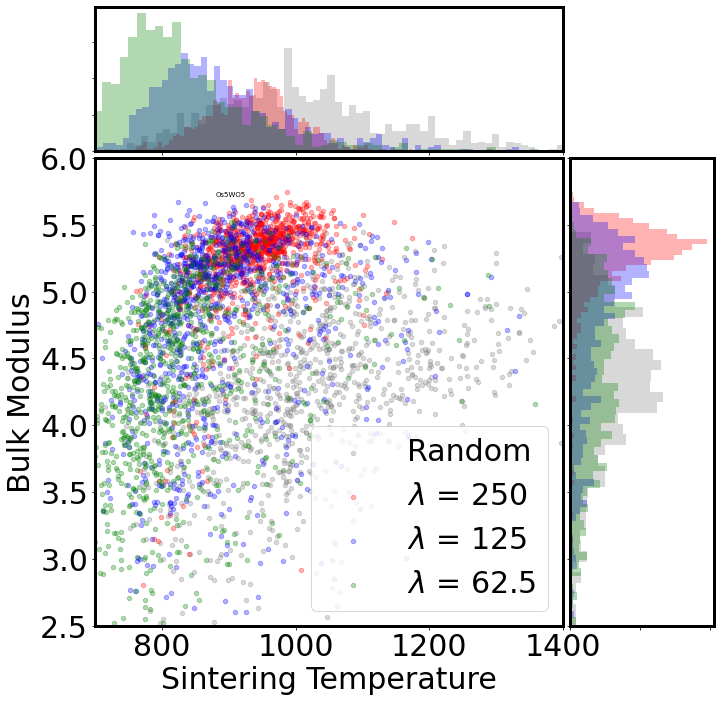

In [157]:
compounds_to_check = []
# 2D plot
# definitions for the axes
colors = ['red', 'blue', 'green']
alpha = 0.3
bins = 75

left, width = 0.1, 0.65
bottom, height = 0.1, 0.65
spacing = 0.01
rect_scatter = [left, bottom, width, height]
rect_histx = [left, bottom + height + spacing, width, 0.2]
rect_histy = [left + width + spacing, bottom, 0.2, height]

fig = plt.figure(figsize=(10,10))
ax = fig.add_axes(rect_scatter)
ax_histx = fig.add_axes(rect_histx, sharex=ax)
ax_histy = fig.add_axes(rect_histy, sharey=ax)

# no labels from histogram
ax_histx.tick_params(axis="x", labelbottom=False)
ax_histx.tick_params(axis="y", labelleft=False)
ax_histy.tick_params(axis="y", labelleft=False)
ax_histy.tick_params(axis="x", labelbottom=False)

ax.scatter(sinter_random, bulk_mod_random, alpha = 0.3, color = 'grey', s = 20, label = 'Random')
ax_histx.hist(sinter_random, color = 'grey', alpha = 0.3, bins = bins)
ax_histy.hist(bulk_mod_random, color = 'grey', alpha = 0.3, bins = bins, orientation='horizontal')

count = 0
for ratio in ratios:
    get_label = lambda x: x.split('-')[1] if (x in ['1-250','1-125']) else '62.5'
    label = get_label(ratio)
    ax.scatter(sinter_dict[ratio], bulk_mod_dict[ratio], color = colors[count], alpha = alpha, s = 20, label = '$\lambda$ = '+ label) 
    ax_histx.hist(sinter_dict[ratio], color = colors[count], alpha = 0.3, bins = bins)
    ax_histy.hist(bulk_mod_dict[ratio], color = colors[count], alpha = 0.3, bins = bins, orientation='horizontal')
    compounds = compounds_dict[ratio]
    
    count += 1

    # labels for compounds on pareto front
    pareto_threshold = 480
    x_weight, y_weight = ratio.split('-') # relative weights for two metrics
    x_weight, y_weight = float(x_weight), float(y_weight)
    for compound, x, y in zip(compounds, sinter_dict[ratio], bulk_mod_dict[ratio]):
        if -x_weight*x + y_weight*y > pareto_threshold: # plot if the combined metric is above a certain threshold
            compound = Composition(compound)
            compound = compound.reduced_formula 
            compounds_to_check.append(compound)
            if compound == 'Os5WO5':
                ax.text(x = x, y = y+0.2, s = compound, size = 7)
                print(x, y)
                print(compound, ratio)

ax.set_xlabel('Sintering Temperature', size = 30)
ax.set_ylabel('Bulk Modulus', size = 30)
ax.tick_params(axis='x', labelsize= 30)
ax.tick_params(axis='y', labelsize= 30)
ax.set_xlim(700, 1400)
plt.ylim(2.5,6)

ax.legend(fontsize = 30)
# plt.savefig(fname = 'plots/NeurIPS_workshop_2022/joint_optimization.png', dpi = 1000)
plt.show()

In [70]:
df = pd.DataFrame()
df['sinter_random'] = sinter_random
df['bulk_mod_random'] = bulk_mod_random
for ratio in ratios:
    get_label = lambda x: x.split('-')[1] if (x in ['1-250','1-125']) else '62.5'
    label = get_label(ratio)
    df['sinter_{}'.format(ratio)], df['bulk_mod_{}'.format(ratio)] = sinter_dict[ratio], bulk_mod_dict[ratio]
df

,sinter_random,bulk_mod_random,sinter_1-250,bulk_mod_1-250,sinter_1-125,bulk_mod_1-125,sinter_1-62,bulk_mod_1-62
0,1078.504167,4.564713,969.837143,5.374899,784.019792,4.130368,861.910000,4.109288
1,848.222500,4.202143,934.047205,5.213277,1113.102711,5.107035,920.769389,4.522017
2,985.951161,4.978990,1048.720060,5.334540,968.534080,5.460206,861.865322,4.939682
3,1055.274982,4.433240,962.808185,5.413830,1156.977237,4.675231,731.903333,3.680496
4,1079.890736,4.932131,931.505915,5.270806,844.064801,5.050420,738.660529,4.770070
...,...,...,...,...,...,...,...,...
995,1076.455089,3.671948,890.837525,4.965373,754.308168,4.414021,739.302033,4.230743
996,1134.098367,4.961004,864.308910,5.273553,827.214008,4.870847,984.131374,4.715594
997,1095.133479,4.143021,947.631499,5.505041,1141.706695,4.962703,1054.486265,2.992527
998,1191.093996,4.960401,921.411935,5.482382,931.969619,5.167592,718.490208,4.282862


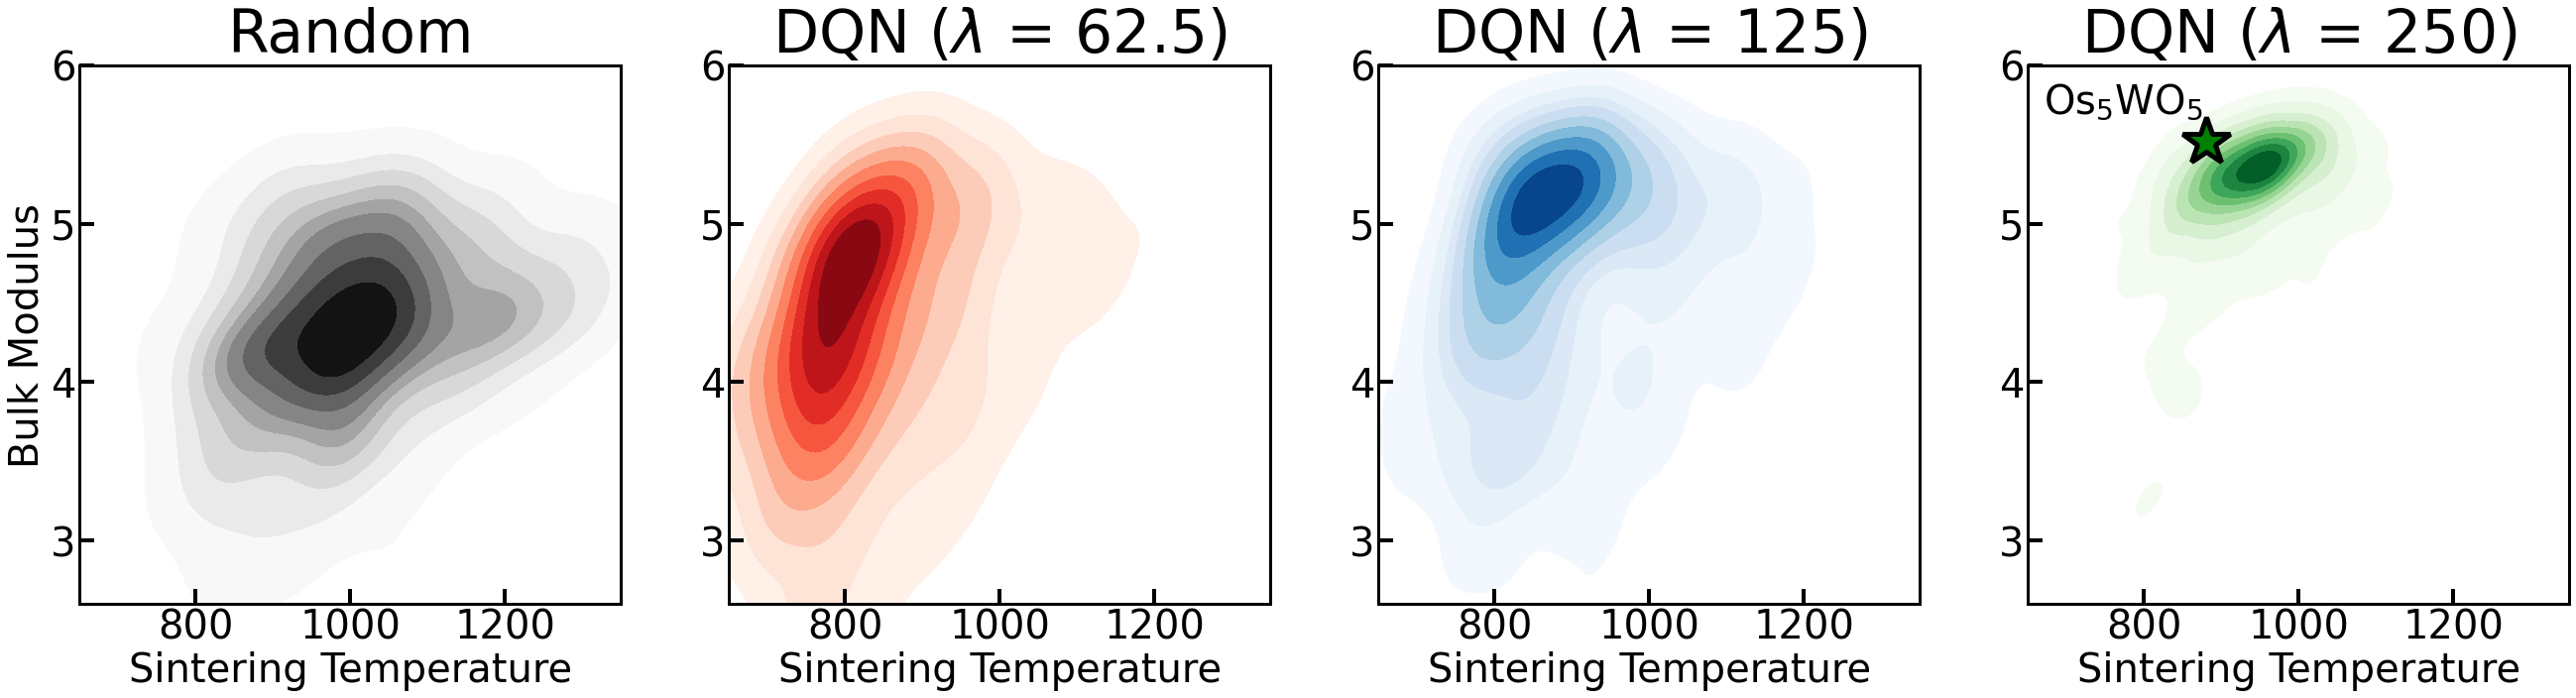

In [183]:
# KDE version
# cmaps = ['Reds', 'Blues', 'Greens']
cmaps = ['Reds', 'Oranges', 'Blues']
alpha = 1
label_size = 40
tick_label_size = 40
title_size = 60
tick_length = 15
tick_width = 4
xlim = [650, 1350]
ylim  = [2.6, 6]
matplotlib.rcParams['axes.linewidth'] = 3

#define figure
fig = plt.figure()
fig.set_figheight(10) # figure height
fig.set_figwidth(45) # figure width

# create grid for different subplots
spec = gridspec.GridSpec(ncols=4, nrows=1,
                            wspace=0.2,
#                          width_ratios=[2, 1], wspace=0.5,
#                          hspace=0.5, height_ratios=[1, 2]
                        )

ax0 = fig.add_subplot(spec[0])
sns.kdeplot(data=df, x="sinter_random", y="bulk_mod_random", fill = True, cmap = 'Greys', alpha = alpha)
ax0.set_title('Random', fontsize = title_size)
ax0.set_xlabel('Sintering Temperature', size = label_size)
ax0.set_ylabel('Bulk Modulus', size = label_size)
ax0.tick_params(axis='x', labelsize= tick_label_size, length = tick_length, width = tick_width, direction = 'in')
ax0.tick_params(axis='y', labelsize= tick_label_size, length = tick_length, width = tick_width, direction = 'in')
# ax.tick_params(direction='out', length=6, width=2, colors='r',
#                grid_color='r', grid_alpha=0.5)
ax0.set_xlim(xlim[0], xlim[1])
plt.ylim(ylim[0], ylim[1])

ax1 = fig.add_subplot(spec[1], sharey = ax0)
sns.kdeplot(data=df, x="sinter_1-62", y="bulk_mod_1-62", fill = True, cmap = 'Reds', alpha = alpha)
ax1.set_title('DQN ($\lambda$ = 62.5)', fontsize = title_size)
ax1.set_xlabel('Sintering Temperature', size = label_size)
ax1.set(ylabel=None)
ax1.tick_params(axis='x', labelsize= tick_label_size, length = tick_length, width = tick_width, direction = 'in')
ax1.tick_params(axis='y', labelsize= tick_label_size, length = tick_length, width = tick_width, direction = 'in')
ax1.set_xlim(xlim[0], xlim[1])
plt.ylim(ylim[0], ylim[1])

ax2 = fig.add_subplot(spec[2])
sns.kdeplot(data=df, x="sinter_1-125", y="bulk_mod_1-125", fill = True, cmap = 'Blues', alpha = alpha)
ax2.set_title('DQN ($\lambda$ = 125)', fontsize = title_size)
ax2.set_xlabel('Sintering Temperature', size = label_size)
ax2.set(ylabel=None)
ax2.tick_params(axis='x', labelsize= tick_label_size, length = tick_length, width = tick_width, direction = 'in')
ax2.tick_params(axis='y', labelsize= tick_label_size, length = tick_length, width = tick_width, direction = 'in')
ax2.set_xlim(xlim[0], xlim[1])
plt.ylim(ylim[0], ylim[1])

ax3 = fig.add_subplot(spec[3])
sns.kdeplot(data=df, x="sinter_1-250", y="bulk_mod_1-250", fill = True, cmap = 'Greens', alpha = alpha)

# Os5WO5$
ax3.plot([880.6949242424243], [5.514501571655273], marker = '*', markersize = 50, color = 'green', 
                                                                markeredgewidth = 5, markeredgecolor = 'black')
ax3.text(670, 5.7, 'Os$_5$WO$_5$', fontsize = 40)

ax3.set_title('DQN ($\lambda$ = 250)', fontsize = title_size)
ax3.set_xlabel('Sintering Temperature', size = label_size)
ax3.set(ylabel=None)
ax3.tick_params(axis='x', labelsize= tick_label_size, length = tick_length, width = tick_width, direction = 'in')
ax3.tick_params(axis='y', labelsize= tick_label_size, length = tick_length, width = tick_width, direction = 'in')
ax3.set_xlim(xlim[0], xlim[1])
plt.ylim(ylim[0], ylim[1])

# fig.savefig('plots/NeurIPS_workshop_2022/joint_optimization_kde.png', dpi = 300)

fig.show()

In [3]:
# predict formation energies of generated compounds
for prop in ["bulk_mod", "shear_mod", "sinter"]:
    if prop == 'sinter':
        model = "RF"
    else:
        model = "roost"
    with open(f'./training_data/oxides_{prop}/final_compounds_{model}_constrained.pkl', 'rb') as handle:
        final_compounds = pickle.load(handle)
    formation_energies = []
    for compound in tqdm(final_compounds):
        try:
            formation_energies.append(predict_formation_energy(compound))
        except:
            print('err')
    print(prop)
    print(np.mean(formation_energies))
    print(np.std(formation_energies))
    print('----')


100%|██████████| 1000/1000 [01:18<00:00, 12.73it/s]


bulk_mod
-0.5865682663426269
0.43989968846819255
----


100%|██████████| 1000/1000 [01:34<00:00, 10.60it/s]


shear_mod
-1.008945337661251
0.5557614353533172
----


100%|██████████| 1000/1000 [01:18<00:00, 12.76it/s]

sinter
-1.0209875393921974
0.507839532848521
----


In [4]:
with open(f'./training_data/oxides_bulk_mod/final_compounds_roost_constrained.pkl', 'rb') as handle:
    final_compounds = pickle.load(handle)

In [5]:
final_compounds[:50]

['Fe3P4Co9O4',
 'V4Fe7Ir7O4',
 'Os5V8Cr1W3O4',
 'Al1Ir2Co7Ru4O4',
 'C5Al9B4O4',
 'Fe4Ir1Ir7Ta3O4',
 'C5Ir6Ti8O5',
 'Cr4Ru6Ti4Fe1O4',
 'Mo1Re4Re5V5O4',
 'Re1Ir4Ir6O4',
 'C4C4W5O4O1',
 'Rh4Os1Al1O5',
 'Al6Fe3Re9Ti4O1',
 'Al4V2Re2B2O5',
 'Zr6Fe7Re1Ru4O8',
 'Cr9Re2Ru3Rh7O5',
 'Ru4Os2Re9B8O1',
 'Rh5Os5Os1O4',
 'Cr9V6V7O4',
 'C4Ge2Mo4Ti2O5',
 'Cr6Al4Rh2Cr2O5',
 'Al5Co4Ru2Co7O4',
 'Ir3Cr3Ru4Cr8O5',
 'W4Fe9Ir1Re9O5',
 'Ni4Ir4Mo4Cr9O5',
 'V8V7Co1O5',
 'Ir8W1Fe9O4',
 'Re2V4O5',
 'Os7Os5V7Co9O5',
 'Fe9Re7P2O4',
 'C9C2Ti6Mo2O1',
 'Al4Ir6Co4O4',
 'Rh3Re6Re4Re3O4',
 'Re9Ir7Rh4B6O4',
 'C3Al8Re9Ta3O1',
 'Ru5Ir8Rh9O5',
 'Ru3Co7Ru1Re1O5',
 'Cr2Cr1O4',
 'Re2Ir7Os9O4',
 'Ru3Os1Ga4Nb1O1',
 'Ir1Rh3Re2B8O1',
 'Os1V2O4',
 'Ru5Re7Rh4Be1O4',
 'Re8W7O5',
 'V7W2Os4O4',
 'Cr7Os6Ir3O4',
 'Ni4Ti7Ru8Co9O5',
 'Cr9Ir3Ru6O4',
 'Ru3Os8Re7O5',
 'W5Rh7O4']